# SARIMAX
This notebook builds on top of <i>Simple_ARIMA</i> and <i>Time Series Regression</i> notebooks. It combines the already identified SARIMA model with <u>Time Series Regression</u> to develop a dynamic regression solution. It is expected that this approach will be the most superior solution compared to all other approaches applied in this project.
>- Exogenous variables ($X$) are added to explain some of the additional deterministic variation in the dependent variable ($Y$). becuase external regressors are used without anz need for differencing, the internal structure of the series (ACF/ PACF) can change. Structure can be seen in the ACF/PACF plots for residuals.
>- This means that the appropriate order for the AR and MA components of the SARIMA models might be changed. In other words, re-assessment of orders might be needed.
>- Regression residuals were already found to be <i>stationary</i>, suggesting that differencing may not be required.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Loading the data
load_long = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 6 (TU Dresden)\Thesis Work\Exploratory Code\load_history_long.csv").sort_values(by = "timestamp")

# Filtering for Zone 1, applying log transformation on load (after rescaling)
load_long_z1 = load_long
load_long_z1["load_rs"] = load_long_z1.load / 1000
load_long_z1["log_load_rs"] = np.log(load_long_z1.load_rs)
load_long_z1 = load_long_z1.loc[load_long_z1.zone_id == 1,:].sort_values(by = "timestamp").reset_index(drop=True)
load_long_z1.head()

C:\Users\singh\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


zone_id  year  month  day   hour     load            timestamp  load_rs  \
0        1  2004      1    1  00:30  16853.0  2004-01-01 00:30:00   16.853   
1        1  2004      1    1  01:30  16450.0  2004-01-01 01:30:00   16.450   
2        1  2004      1    1  02:30  16517.0  2004-01-01 02:30:00   16.517   
3        1  2004      1    1  03:30  16873.0  2004-01-01 03:30:00   16.873   
4        1  2004      1    1  04:30  17064.0  2004-01-01 04:30:00   17.064   

   log_load_rs  
0     2.824529  
1     2.800325  
2     2.804390  
3     2.825715  
4     2.836971

Variance stabilisation is already done by rescaling the data and applying <b>log transformation</b> to the load values.<br>
The transformed values are represented by <i>log_load_rs</i> column.

In [3]:
# Loading the temperature data
temperature = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 6 (TU Dresden)\Thesis Work\Exploratory Code\weighted_temperature.csv")
temperature.head()

timestamp     1     2     3     4     5     6     7     8     9  \
0  2004-01-01 00:30:00  46.0  38.0  44.0  45.0  42.0  44.0  45.0  43.0  41.0   
1  2004-01-01 01:30:00  46.0  36.0  42.0  43.0  42.0  43.0  44.0  44.0  39.0   
2  2004-01-01 02:30:00  45.0  35.0  40.0  41.0  40.0  42.0  41.0  42.0  36.0   
3  2004-01-01 03:30:00  41.0  30.0  36.0  37.0  39.0  38.0  40.0  34.0  35.0   
4  2004-01-01 04:30:00  39.0  30.0  34.0  33.0  40.0  38.0  35.0  30.0  33.0   

     10    11  temp_weighted  
0  42.0  36.0      42.338937  
1  43.0  32.0      41.239284  
2  43.0  31.0      39.591442  
3  39.0  30.0      36.243296  
4  35.0  34.0      34.600850

## Processing the Data

In [4]:
# Filtering load for 2004
load_long_z1_2004 = load_long_z1.loc[load_long_z1.year == 2004, ['timestamp','year','month','day','hour','log_load_rs']]

# Filtering temperature for 2004
temperature_2004 = temperature.loc[temperature.timestamp <= '2004-12-31 23:30:00', ['timestamp', 'temp_weighted']]

# Combining load and temperature information
mul_df = load_long_z1_2004.merge(temperature_2004, on='timestamp', how='left')
mul_df.head()

timestamp  year  month  day   hour  log_load_rs  temp_weighted
0  2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937
1  2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284
2  2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442
3  2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296
4  2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850

Fourier terms are made differently for each portion of 2004. Hence they will be defined while testing for that particular period.

In [5]:
# Adding temperature knots for PLR

T_H = 55  # Heating Threshold
T_C = 65  # Cooling Threshold

# Construct the Heating Demand Knot: HDK = max(0, T_H - Temp)
## This captures load increase when temp is below T_H.
mul_df["HDK"] = np.where(
    mul_df["temp_weighted"] < T_H,  
    T_H - mul_df["temp_weighted"],  # Value if True: The positive difference
    0                               # Value if False: Zero
)

# Construct the Cooling Demand Knot; CDK = max(0, Temp - T_C)
## This captures load increase when temp is above T_C.
mul_df["CDK"] = np.where(
    mul_df["temp_weighted"] > T_C,  
    mul_df["temp_weighted"] - T_C,  # Value if True: The positive difference
    0                               # Value if False: Zero
)

mul_df.head()

timestamp  year  month  day   hour  log_load_rs  temp_weighted  \
0  2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
1  2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2  2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
3  2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
4  2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

         HDK  CDK  
0  12.661063  0.0  
1  13.760716  0.0  
2  15.408558  0.0  
3  18.756704  0.0  
4  20.399150  0.0

## Combining Fourier Terms with SARIMAX
The model combines regressors in addition to fourier terms, as used in time series regression. Together they make all exogenous regressors. This is then combined with SARIMAX, where seasonal AR\MA components are also defined.

##### Testing on Last Week of Jan 2004 (Zone 1)
Last week of Jan 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [6]:
# Creating training data
load_long_z1_2004_jan_train = mul_df.loc[mul_df.month == 1,:]
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train.set_index("timestamp")
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train[:'2004-01-24 23:30:00']
load_long_z1_2004_jan_train.index = pd.to_datetime(load_long_z1_2004_jan_train.index)
load_long_z1_2004_jan_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

                           HDK  CDK  
timestamp                            
2004-01-01 00:30:00  12.661063  0.0  
2004-01-01 01:30:00  13.760716  0.0  
2004-01-01 02:30:00  15.408558  0.0  
2004-01-01 03:30:00  18.756704  0.0  
2004-01-01 04:30:00  20.399150  0.0

From time series regression notebook, 2 harmonics with daily periodicity were found to be appropriate. However, trend term is not added, rather the SARIMAX model is allowed to define the trend term.

In [7]:
# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess
periodicity = Fourier(period=24, order=2) # daily cycle i.e. 24 hours, 2 harmonics

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jan_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=True,      # defined here for intercept
    order=1,             # linear trend defined here
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()
waves.head()

const  trend  sin(1,24)  cos(1,24)  sin(2,24)  \
timestamp                                                            
2004-01-01 00:30:00    1.0    1.0   0.000000   1.000000   0.000000   
2004-01-01 01:30:00    1.0    2.0   0.258819   0.965926   0.500000   
2004-01-01 02:30:00    1.0    3.0   0.500000   0.866025   0.866025   
2004-01-01 03:30:00    1.0    4.0   0.707107   0.707107   1.000000   
2004-01-01 04:30:00    1.0    5.0   0.866025   0.500000   0.866025   

                        cos(2,24)  
timestamp                          
2004-01-01 00:30:00  1.000000e+00  
2004-01-01 01:30:00  8.660254e-01  
2004-01-01 02:30:00  5.000000e-01  
2004-01-01 03:30:00  6.123234e-17  
2004-01-01 04:30:00 -5.000000e-01

In [8]:
# Combining fourier terms with other variables
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jan_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

                           HDK  CDK  const  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                 
2004-01-01 00:30:00  12.661063  0.0    1.0    1.0   0.000000   1.000000   
2004-01-01 01:30:00  13.760716  0.0    1.0    2.0   0.258819   0.965926   
2004-01-01 02:30:00  15.408558  0.0    1.0    3.0   0.500000   0.866025   
2004-01-01 03:30:00  18.756704  0.0    1.0    4.0   0.707107   0.707107   
2004-01-01 04:30:00  20.399150  0.0    1.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-01-01 00:30:00   0.000000  1.000000e+00  
2004-01-01 01:30:00   0.500000  8.660254e-01  
2004-01-01 02:30:00   0.866025  5.000000e-01  
2004-01-01 03:30:00   1.000000  6.123234e-17  
2004-01-01 04:30:00   0.866025 -5.000000e-01

The trend and intercept are included as part of the exog variables, since they are needed in the determinisitic (regression) part of the model. Hence, these parameters need to be explicitly switched-off in the stochastic (SARIMA) part of the model, so that SARIMA can solely focus on serial dependence.

In [9]:
# Comparing models - auto_arima (no differencing since regr res are stationary)

import pmdarima as pm
smodel_jan = pm.auto_arima(y = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jan_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=3, max_Q=3, seasonal=True,
                           d=0, D=0, trace=True,
                           with_intercept=False,
                           trend="n",
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-1042.544, Time=1.04 sec
 ARIMA(1,0,0)(1,0,0)[24]             : AIC=-2070.885, Time=8.69 sec
 ARIMA(0,0,1)(0,0,1)[24]             : AIC=-1312.018, Time=10.86 sec
 ARIMA(1,0,0)(0,0,0)[24]             : AIC=-1982.262, Time=0.50 sec
 ARIMA(1,0,0)(2,0,0)[24]             : AIC=-2058.418, Time=19.49 sec
 ARIMA(1,0,0)(1,0,1)[24]             : AIC=-2067.866, Time=5.45 sec
 ARIMA(1,0,0)(0,0,1)[24]             : AIC=-2061.100, Time=4.06 sec
 ARIMA(1,0,0)(2,0,1)[24]             : AIC=-2055.651, Time=15.35 sec
 ARIMA(0,0,0)(1,0,0)[24]             : AIC=-1107.438, Time=4.00 sec
 ARIMA(2,0,0)(1,0,0)[24]             : AIC=-2129.480, Time=4.74 sec
 ARIMA(2,0,0)(0,0,0)[24]             : AIC=-2067.475, Time=1.05 sec
 ARIMA(2,0,0)(2,0,0)[24]             : AIC=-2087.827, Time=7.59 sec
 ARIMA(2,0,0)(1,0,1)[24]             : AIC=-2123.322, Time=5.19 sec
 ARIMA(2,0,0)(0,0,1)[24]             : AIC=-2120.717, Time=8.93 sec
 A

The order of the seasonal and non-seasonal AR/MA components has now changed, compared to the case of using SARIMAX without external regressors.
<br>
However, an important warining about AutoARIMA: 
> Note that due to stationarity issues, auto-ARIMA might not find a suitable model that will converge.

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


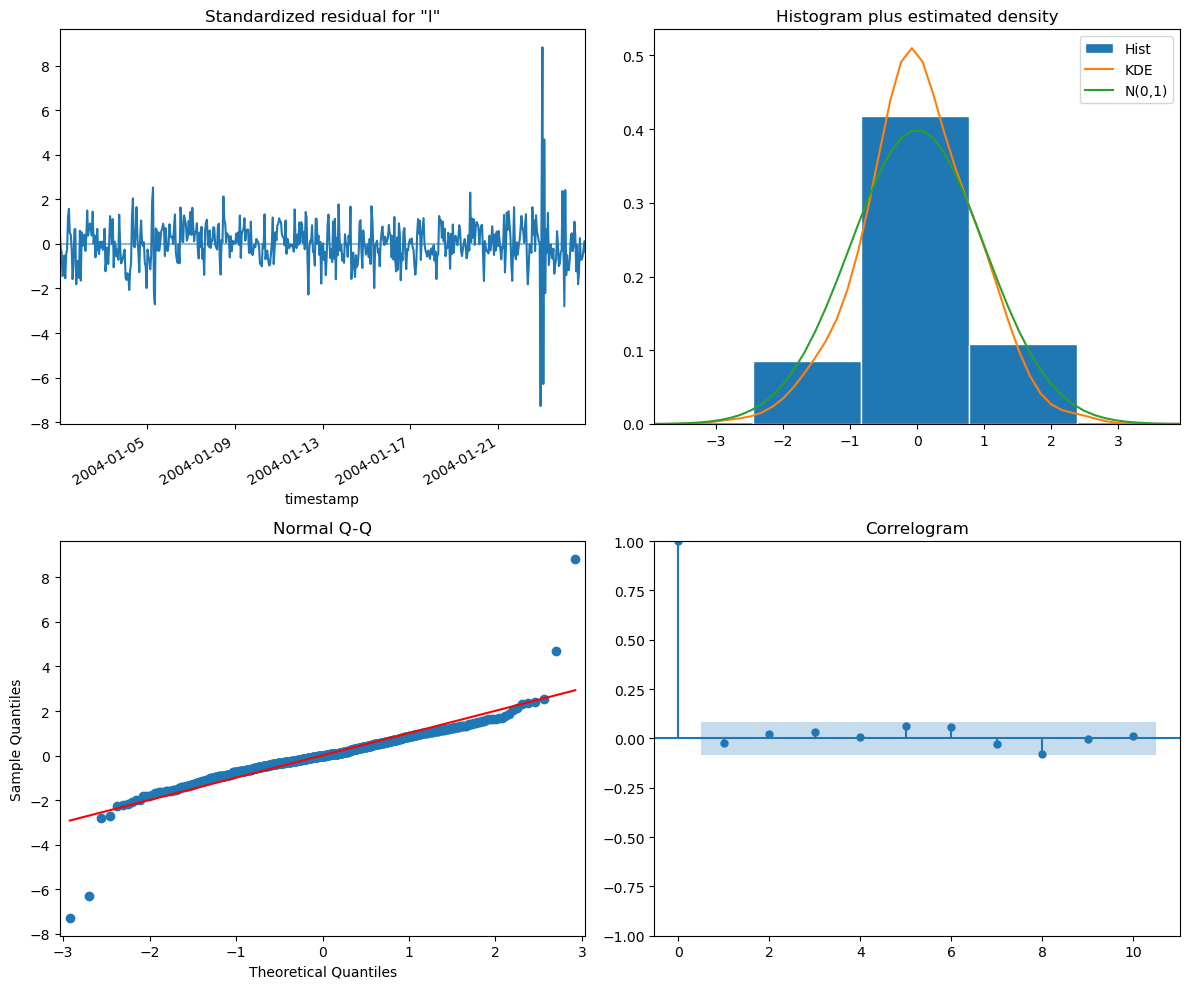

In [10]:
# Diagnostics; (1,0,1)(1,0,0)

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jan_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(1,0,1),  # non-seasonal: with no differencing
        seasonal_order=(1,0,0,24), # seasonal: with seasonal differencing
        trend=None,
        enforce_stationarity=True,
        enforce_invertibility=True)

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

The model is not showing convergence, trying a simpler model...

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


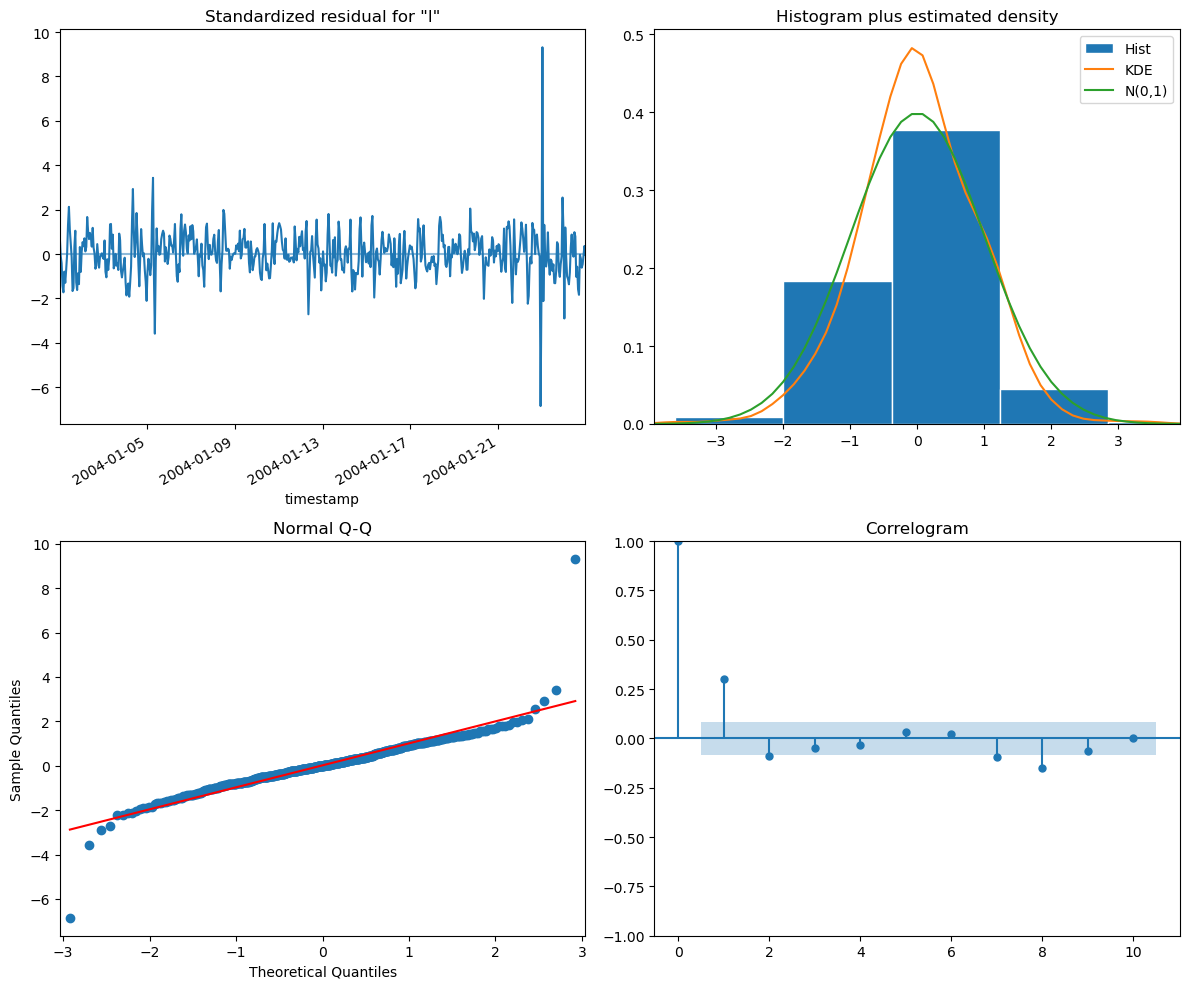

In [11]:
# Diagnostics; (1,0,0)(1,0,0)

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jan_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(1,0,0),  # non-seasonal: with no differencing
        seasonal_order=(1,0,0,24), # seasonal: with seasonal differencing
        trend=None,
        enforce_stationarity=True,
        enforce_invertibility=True)

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Again, the model didn't show convergence. Trying a different simpler model...

In [ ]:
# Diagnostics; (1,0,1)(0,0,0)

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jan_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(1,0,1),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24), # seasonal: with seasonal differencing
        trend=None,
        enforce_stationarity=True,
        enforce_invertibility=True)

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

It converges this time. Residual plot appears to have slightly improved, but deviation is still heavy at tails.
> Distribution more similar to Gaussian dist.

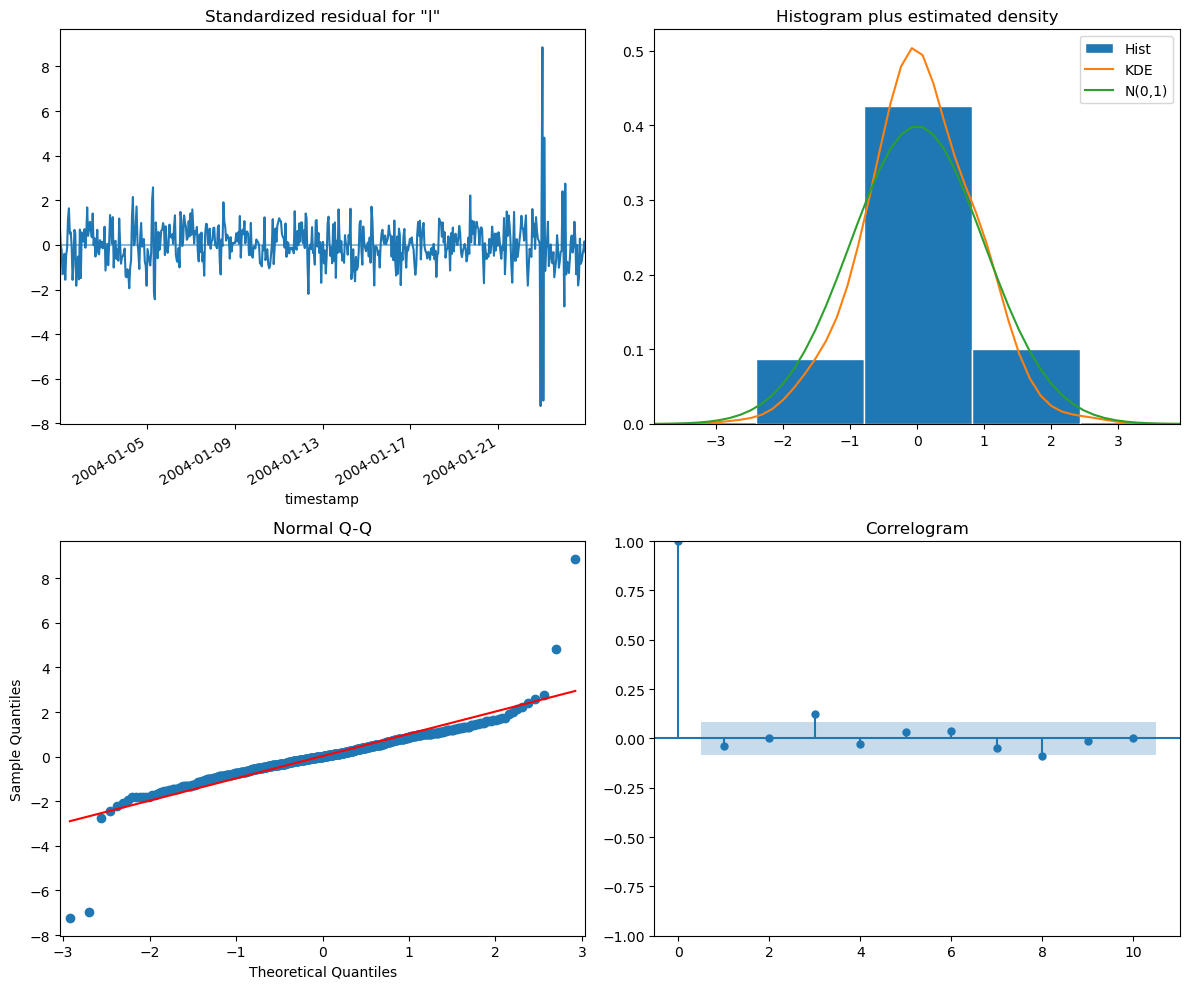

In [12]:
# Diagnostics FINAL MODEL; (3,0,0)(1,0,0)

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jan_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(1,0,0,24), # seasonal: with seasonal differencing
        trend=None,
        enforce_stationarity=True,
        enforce_invertibility=True)

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [13]:
# Creating test data
load_long_z1_2004_jan_test = mul_df.loc[mul_df.month == 1,:]
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test.set_index("timestamp")
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test['2004-01-25 00:30:00':]
load_long_z1_2004_jan_test.index = pd.to_datetime(load_long_z1_2004_jan_test.index)
load_long_z1_2004_jan_test["col_of_ones"] = 1
load_long_z1_2004_jan_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-25 00:30:00  2004      1   25  00:30     3.094174      21.155292   
2004-01-25 01:30:00  2004      1   25  01:30     3.101713      20.058817   
2004-01-25 02:30:00  2004      1   25  02:30     3.144626      19.051006   
2004-01-25 03:30:00  2004      1   25  03:30     3.160441      18.246300   
2004-01-25 04:30:00  2004      1   25  04:30     3.197407      17.700175   

                           HDK  CDK  col_of_ones  
timestamp                                         
2004-01-25 00:30:00  33.844708  0.0            1  
2004-01-25 01:30:00  34.941183  0.0            1  
2004-01-25 02:30:00  35.948994  0.0            1  
2004-01-25 03:30:00  36.753700  0.0            1  
2004-01-25 04:30:00  37.299825  0.0            1

In [14]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jan_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=True,      # intercept defined here
    order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()
waves.head()

const  trend  sin(1,24)  cos(1,24)  sin(2,24)  \
timestamp                                                            
2004-01-25 00:30:00    1.0    1.0   0.000000   1.000000   0.000000   
2004-01-25 01:30:00    1.0    2.0   0.258819   0.965926   0.500000   
2004-01-25 02:30:00    1.0    3.0   0.500000   0.866025   0.866025   
2004-01-25 03:30:00    1.0    4.0   0.707107   0.707107   1.000000   
2004-01-25 04:30:00    1.0    5.0   0.866025   0.500000   0.866025   

                        cos(2,24)  
timestamp                          
2004-01-25 00:30:00  1.000000e+00  
2004-01-25 01:30:00  8.660254e-01  
2004-01-25 02:30:00  5.000000e-01  
2004-01-25 03:30:00  6.123234e-17  
2004-01-25 04:30:00 -5.000000e-01

In [15]:
# Combining fourier terms with other variables - test set
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jan_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-25 00:30:00  2004      1   25  00:30     3.094174      21.155292   
2004-01-25 01:30:00  2004      1   25  01:30     3.101713      20.058817   
2004-01-25 02:30:00  2004      1   25  02:30     3.144626      19.051006   
2004-01-25 03:30:00  2004      1   25  03:30     3.160441      18.246300   
2004-01-25 04:30:00  2004      1   25  04:30     3.197407      17.700175   

                           HDK  CDK  col_of_ones  const  trend  sin(1,24)  \
timestamp                                                                   
2004-01-25 00:30:00  33.844708  0.0            1    1.0    1.0   0.000000   
2004-01-25 01:30:00  34.941183  0.0            1    1.0    2.0   0.258819   
2004-01-25 02:30:00  35.948994  0.0            1    1.0    3.0   0.500000   
2004-01-25 03:30:00  36.753700  0.0            1    1.0    4.0   0.707107   
2004-01-25 04:30:00  37.299825  0.0            1    1.0    5.0   0.866025   

                     cos(1,24)  sin(2,24)     cos(2,24)  
timestamp                                                
2004-01-25 00:30:00   1.000000   0.000000  1.000000e+00  
2004-01-25 01:30:00   0.965926   0.500000  8.660254e-01  
2004-01-25 02:30:00   0.866025   0.866025  5.000000e-01  
2004-01-25 03:30:00   0.707107   1.000000  6.123234e-17  
2004-01-25 04:30:00   0.500000   0.866025 -5.000000e-01

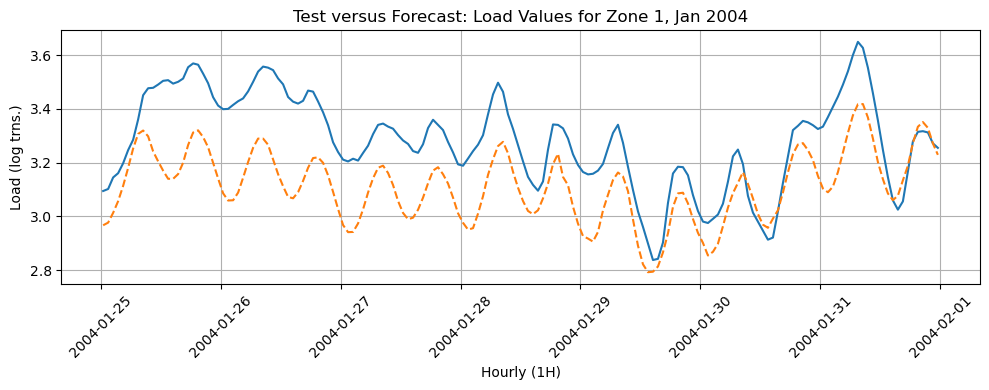

In [16]:
# Predicting 24*7 steps ahead
forecast_jan04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jan_test[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]]
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jan_test, x=load_long_z1_2004_jan_test.index, y=load_long_z1_2004_jan_test["log_load_rs"], ax=ax)
sns.lineplot(forecast_jan04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jan 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [17]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}")
print(f'RMSE score: {np.sqrt(mean_squared_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')

R2 score: -0.2961712310479443
RMSE score: 0.1989649831334583
MAE score: 0.17492705170362893
MAPE score: 0.0524220945190487


Performance improvement is significant and much better that ES.

##### Testing on Last Week of Apr 2004 (Zone 1)
Last week of Apr 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [18]:
# Creating training data
load_long_z1_2004_apr_train = mul_df.loc[mul_df.month == 4,:]
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train.set_index("timestamp")
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train[:'2004-04-23 23:30:00']
load_long_z1_2004_apr_train.index = pd.to_datetime(load_long_z1_2004_apr_train.index)
load_long_z1_2004_apr_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-01 00:30:00  2004      4    1  00:30     2.645820      45.453562   
2004-04-01 01:30:00  2004      4    1  01:30     2.633901      45.547368   
2004-04-01 02:30:00  2004      4    1  02:30     2.633039      45.454863   
2004-04-01 03:30:00  2004      4    1  03:30     2.646246      45.454863   
2004-04-01 04:30:00  2004      4    1  04:30     2.688528      45.191047   

                          HDK  CDK  
timestamp                           
2004-04-01 00:30:00  9.546438  0.0  
2004-04-01 01:30:00  9.452632  0.0  
2004-04-01 02:30:00  9.545137  0.0  
2004-04-01 03:30:00  9.545137  0.0  
2004-04-01 04:30:00  9.808953  0.0

In [19]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_apr_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=True,      # intercept 
    order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_apr_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-01 00:30:00  2004      4    1  00:30     2.645820      45.453562   
2004-04-01 01:30:00  2004      4    1  01:30     2.633901      45.547368   
2004-04-01 02:30:00  2004      4    1  02:30     2.633039      45.454863   
2004-04-01 03:30:00  2004      4    1  03:30     2.646246      45.454863   
2004-04-01 04:30:00  2004      4    1  04:30     2.688528      45.191047   

                          HDK  CDK  const  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                
2004-04-01 00:30:00  9.546438  0.0    1.0    1.0   0.000000   1.000000   
2004-04-01 01:30:00  9.452632  0.0    1.0    2.0   0.258819   0.965926   
2004-04-01 02:30:00  9.545137  0.0    1.0    3.0   0.500000   0.866025   
2004-04-01 03:30:00  9.545137  0.0    1.0    4.0   0.707107   0.707107   
2004-04-01 04:30:00  9.808953  0.0    1.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-04-01 00:30:00   0.000000  1.000000e+00  
2004-04-01 01:30:00   0.500000  8.660254e-01  
2004-04-01 02:30:00   0.866025  5.000000e-01  
2004-04-01 03:30:00   1.000000  6.123234e-17  
2004-04-01 04:30:00   0.866025 -5.000000e-01

In [69]:
# Comparing models - auto_arima (no differencing since regr res are stationary)

import pmdarima as pm
smodel_apr = pm.auto_arima(y = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_apr_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=3, max_Q=3, seasonal=True,
                           d=0, D=0, trace=True,
                           with_intercept=False,
                           trend=None,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-840.022, Time=0.64 sec
 ARIMA(1,0,0)(1,0,0)[24]             : AIC=-2023.894, Time=5.35 sec
 ARIMA(0,0,1)(0,0,1)[24]             : AIC=-930.770, Time=2.01 sec
 ARIMA(1,0,0)(0,0,0)[24]             : AIC=-1750.590, Time=0.34 sec
 ARIMA(1,0,0)(2,0,0)[24]             : AIC=-2031.211, Time=15.06 sec
 ARIMA(1,0,0)(3,0,0)[24]             : AIC=-1997.781, Time=30.74 sec
 ARIMA(1,0,0)(2,0,1)[24]             : AIC=-2027.121, Time=16.55 sec
 ARIMA(1,0,0)(1,0,1)[24]             : AIC=-2030.317, Time=6.21 sec
 ARIMA(1,0,0)(3,0,1)[24]             : AIC=-2021.377, Time=33.22 sec
 ARIMA(0,0,0)(2,0,0)[24]             : AIC=-988.670, Time=4.36 sec
 ARIMA(2,0,0)(2,0,0)[24]             : AIC=-2161.768, Time=15.29 sec
 ARIMA(2,0,0)(1,0,0)[24]             : AIC=-2162.254, Time=5.79 sec
 ARIMA(2,0,0)(0,0,0)[24]             : AIC=-1927.434, Time=0.57 sec
 ARIMA(2,0,0)(1,0,1)[24]             : AIC=-2168.901, Time=7.51 sec
 AR

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


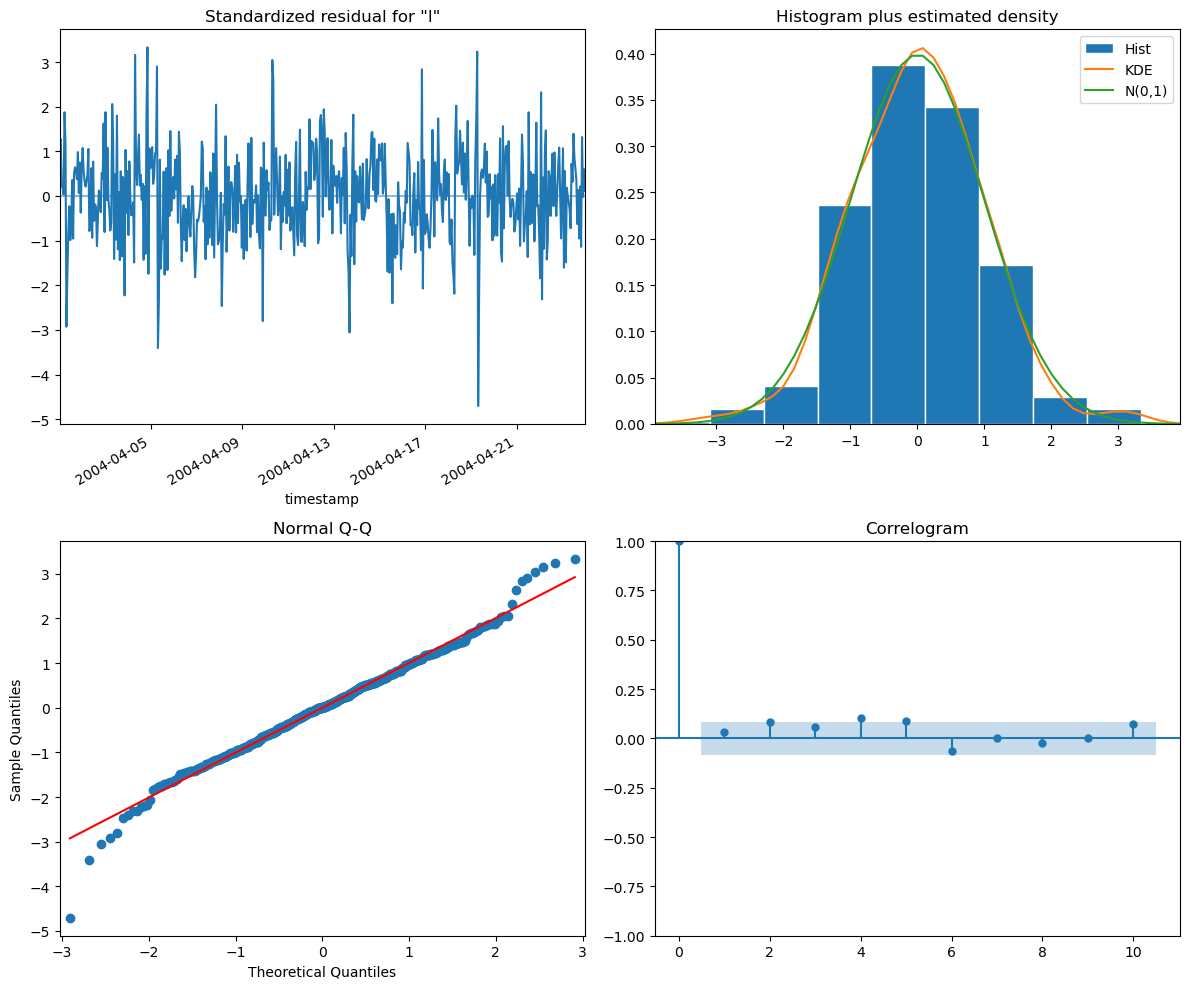

In [70]:
# Diagnostics, (3,0,0)(2,0,1)

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_apr_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(2,0,1,24), # seasonal: with seasonal differencing
        trend=None,
        enforce_stationarity=True,
        enforce_invertibility=True)

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

The model failed to converge, trying a model with lower order...

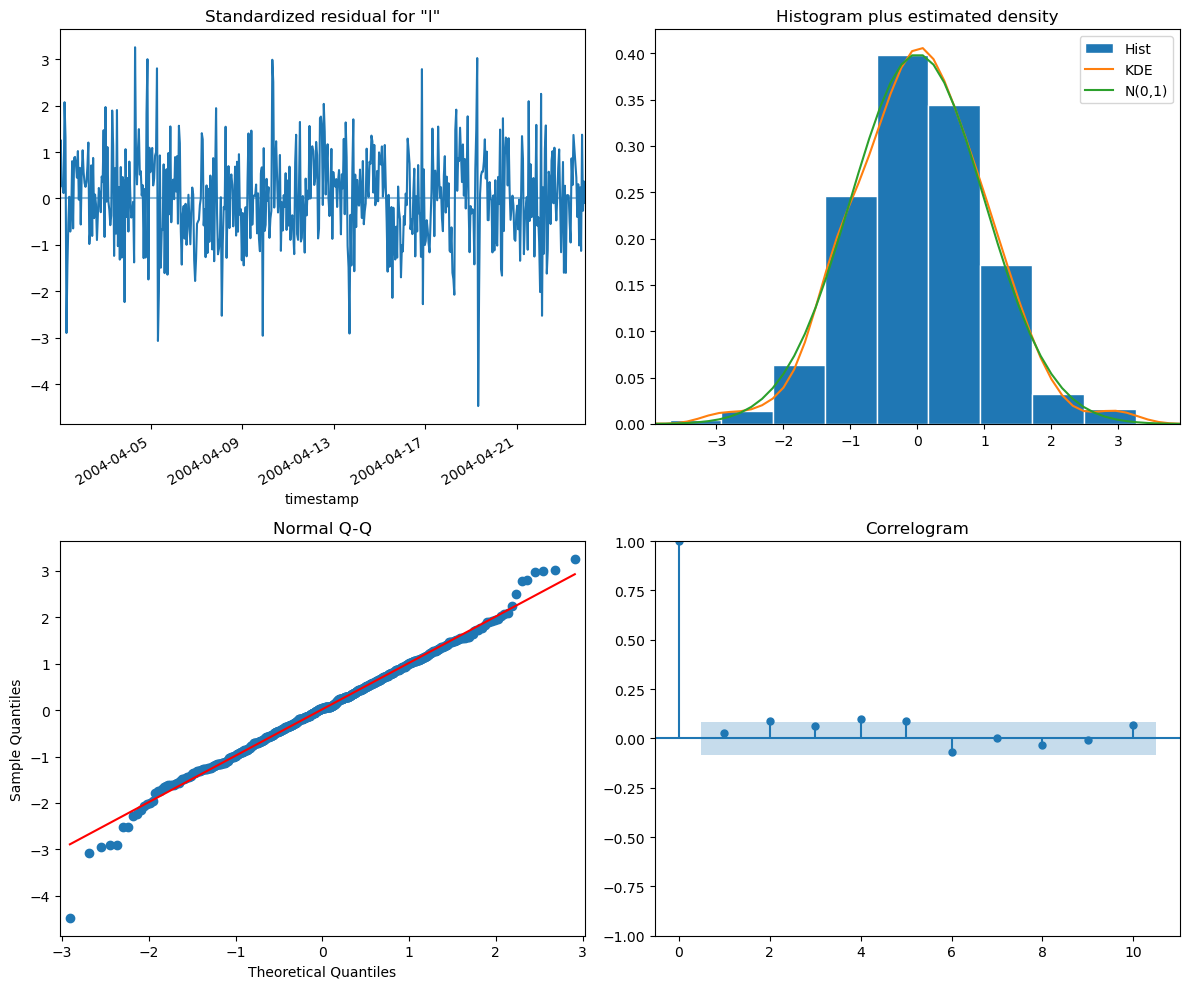

In [71]:
# Diagnostics; (3,0,0)(2,0,0)

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_apr_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(2,0,0,24), # seasonal: with seasonal differencing
        trend=None,
        enforce_stationarity=True,
        enforce_invertibility=True)

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model successfully converged.

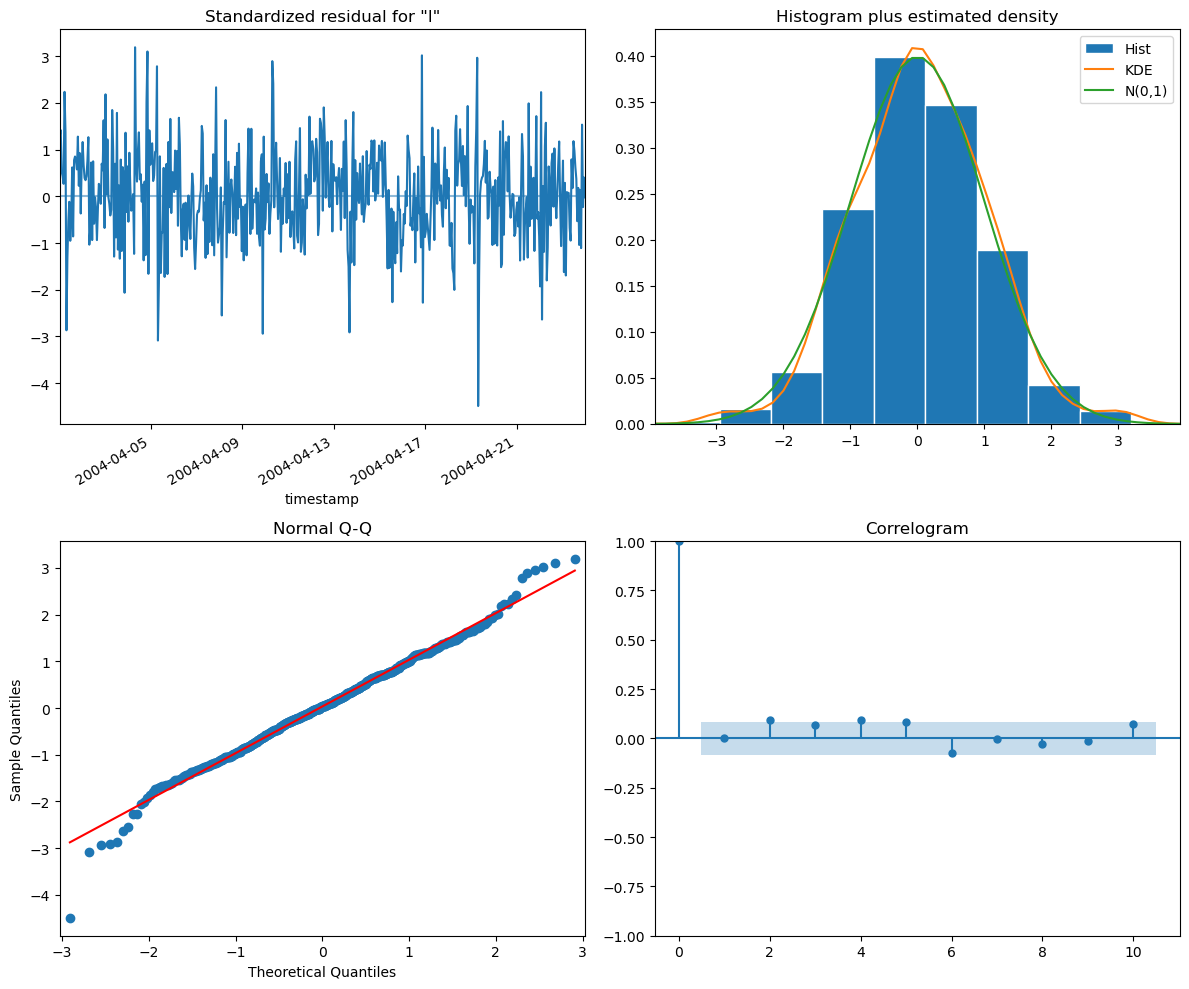

In [20]:
# Diagnostics FINAL MODEL; (3,0,0)(1,0,0)

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_apr_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(1,0,0,24), # seasonal: with seasonal differencing
        trend=None,
        enforce_stationarity=True,
        enforce_invertibility=True)

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [21]:
# Creating test data
load_long_z1_2004_apr_test = mul_df.loc[mul_df.month == 4,:]
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test.set_index("timestamp")
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test['2004-04-24 00:30:00':]
load_long_z1_2004_apr_test.index = pd.to_datetime(load_long_z1_2004_apr_test.index)
load_long_z1_2004_apr_test.head()

year  month  day   hour  log_load_rs  temp_weighted  HDK  \
timestamp                                                                       
2004-04-24 00:30:00  2004      4   24  00:30     2.437728      62.266565  0.0   
2004-04-24 01:30:00  2004      4   24  01:30     2.328643      62.708075  0.0   
2004-04-24 02:30:00  2004      4   24  02:30     2.279316      61.449205  0.0   
2004-04-24 03:30:00  2004      4   24  03:30     2.249290      60.634717  0.0   
2004-04-24 04:30:00  2004      4   24  04:30     2.248657      59.824237  0.0   

                     CDK  
timestamp                 
2004-04-24 00:30:00  0.0  
2004-04-24 01:30:00  0.0  
2004-04-24 02:30:00  0.0  
2004-04-24 03:30:00  0.0  
2004-04-24 04:30:00  0.0

In [22]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_apr_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=True,      # intercept 
    order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_apr_test.head()

year  month  day   hour  log_load_rs  temp_weighted  HDK  \
timestamp                                                                       
2004-04-24 00:30:00  2004      4   24  00:30     2.437728      62.266565  0.0   
2004-04-24 01:30:00  2004      4   24  01:30     2.328643      62.708075  0.0   
2004-04-24 02:30:00  2004      4   24  02:30     2.279316      61.449205  0.0   
2004-04-24 03:30:00  2004      4   24  03:30     2.249290      60.634717  0.0   
2004-04-24 04:30:00  2004      4   24  04:30     2.248657      59.824237  0.0   

                     CDK  const  trend  sin(1,24)  cos(1,24)  sin(2,24)  \
timestamp                                                                 
2004-04-24 00:30:00  0.0    1.0    1.0   0.000000   1.000000   0.000000   
2004-04-24 01:30:00  0.0    1.0    2.0   0.258819   0.965926   0.500000   
2004-04-24 02:30:00  0.0    1.0    3.0   0.500000   0.866025   0.866025   
2004-04-24 03:30:00  0.0    1.0    4.0   0.707107   0.707107   1.000000   
2004-04-24 04:30:00  0.0    1.0    5.0   0.866025   0.500000   0.866025   

                        cos(2,24)  
timestamp                          
2004-04-24 00:30:00  1.000000e+00  
2004-04-24 01:30:00  8.660254e-01  
2004-04-24 02:30:00  5.000000e-01  
2004-04-24 03:30:00  6.123234e-17  
2004-04-24 04:30:00 -5.000000e-01

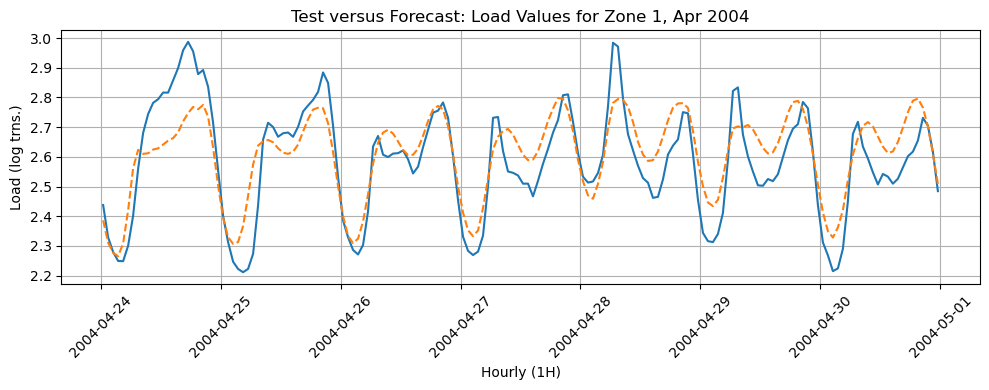

In [23]:
# Predicting 24*7 steps ahead
forecast_apr04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_apr_test[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_apr_test, x=load_long_z1_2004_apr_test.index, y=load_long_z1_2004_apr_test.log_load_rs, ax=ax)
sns.lineplot(forecast_apr04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Apr 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [24]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}")
print(f'RMSE score: {np.sqrt(mean_squared_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')

R2 score: 0.6897741347682489
RMSE score: 0.10301267973612553
MAE score: 0.08625748079973453
MAPE score: 0.033516802164768725


##### Testing on Last Week of Jul 2004 (Zone 1)
Last week of Jul 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [25]:
# Creating training data
load_long_z1_2004_jul_train = mul_df.loc[mul_df.month == 7,:]
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train.set_index("timestamp")
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train[:'2004-07-24 23:30:00']
load_long_z1_2004_jul_train.index = pd.to_datetime(load_long_z1_2004_jul_train.index)
load_long_z1_2004_jul_train.head()

year  month  day   hour  log_load_rs  temp_weighted  HDK  \
timestamp                                                                       
2004-07-01 00:30:00  2004      7    1  00:30     2.658230      67.152732  0.0   
2004-07-01 01:30:00  2004      7    1  01:30     2.548507      66.148285  0.0   
2004-07-01 02:30:00  2004      7    1  02:30     2.482404      65.687669  0.0   
2004-07-01 03:30:00  2004      7    1  03:30     2.447464      64.515455  0.0   
2004-07-01 04:30:00  2004      7    1  04:30     2.430626      64.517938  0.0   

                          CDK  
timestamp                      
2004-07-01 00:30:00  2.152732  
2004-07-01 01:30:00  1.148285  
2004-07-01 02:30:00  0.687669  
2004-07-01 03:30:00  0.000000  
2004-07-01 04:30:00  0.000000

In [26]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jul_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=True,      # intercept 
    order=1,             
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jul_train.head()

year  month  day   hour  log_load_rs  temp_weighted  HDK  \
timestamp                                                                       
2004-07-01 00:30:00  2004      7    1  00:30     2.658230      67.152732  0.0   
2004-07-01 01:30:00  2004      7    1  01:30     2.548507      66.148285  0.0   
2004-07-01 02:30:00  2004      7    1  02:30     2.482404      65.687669  0.0   
2004-07-01 03:30:00  2004      7    1  03:30     2.447464      64.515455  0.0   
2004-07-01 04:30:00  2004      7    1  04:30     2.430626      64.517938  0.0   

                          CDK  const  trend  sin(1,24)  cos(1,24)  sin(2,24)  \
timestamp                                                                      
2004-07-01 00:30:00  2.152732    1.0    1.0   0.000000   1.000000   0.000000   
2004-07-01 01:30:00  1.148285    1.0    2.0   0.258819   0.965926   0.500000   
2004-07-01 02:30:00  0.687669    1.0    3.0   0.500000   0.866025   0.866025   
2004-07-01 03:30:00  0.000000    1.0    4.0   0.707107   0.707107   1.000000   
2004-07-01 04:30:00  0.000000    1.0    5.0   0.866025   0.500000   0.866025   

                        cos(2,24)  
timestamp                          
2004-07-01 00:30:00  1.000000e+00  
2004-07-01 01:30:00  8.660254e-01  
2004-07-01 02:30:00  5.000000e-01  
2004-07-01 03:30:00  6.123234e-17  
2004-07-01 04:30:00 -5.000000e-01

In [78]:
# Comparing models - auto_arima (no differencing since regr res are stationary)

import pmdarima as pm
smodel_jul = pm.auto_arima(y = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jul_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=3, max_Q=3, seasonal=True,
                           d=0, D=0, trace=True,
                           with_intercept=False,
                           trend=None,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-1247.431, Time=0.55 sec
 ARIMA(1,0,0)(1,0,0)[24]             : AIC=-2488.429, Time=5.74 sec


C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1905: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\singh\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:40: RuntimeWarning: invalid value encountered in divide
  max_invroot = max(0, *np.abs(1 / model.maroots()))


 ARIMA(0,0,1)(0,0,1)[24]             : AIC=-1232.904, Time=2.00 sec
 ARIMA(1,0,0)(0,0,0)[24]             : AIC=-2395.820, Time=0.54 sec
 ARIMA(1,0,0)(2,0,0)[24]             : AIC=-2460.964, Time=11.16 sec
 ARIMA(1,0,0)(1,0,1)[24]             : AIC=-2485.745, Time=6.02 sec
 ARIMA(1,0,0)(0,0,1)[24]             : AIC=-2460.070, Time=4.67 sec
 ARIMA(1,0,0)(2,0,1)[24]             : AIC=-2486.532, Time=15.41 sec
 ARIMA(0,0,0)(1,0,0)[24]             : AIC=-1267.245, Time=2.01 sec
 ARIMA(2,0,0)(1,0,0)[24]             : AIC=-2623.872, Time=7.08 sec
 ARIMA(2,0,0)(0,0,0)[24]             : AIC=-2467.319, Time=0.70 sec
 ARIMA(2,0,0)(2,0,0)[24]             : AIC=-2629.556, Time=17.27 sec
 ARIMA(2,0,0)(3,0,0)[24]             : AIC=-2613.006, Time=35.87 sec
 ARIMA(2,0,0)(2,0,1)[24]             : AIC=-2629.979, Time=16.73 sec
 ARIMA(2,0,0)(1,0,1)[24]             : AIC=-2608.729, Time=5.96 sec
 ARIMA(2,0,0)(3,0,1)[24]             : AIC=-2608.739, Time=49.89 sec
 ARIMA(2,0,0)(2,0,2)[24]             : AIC

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


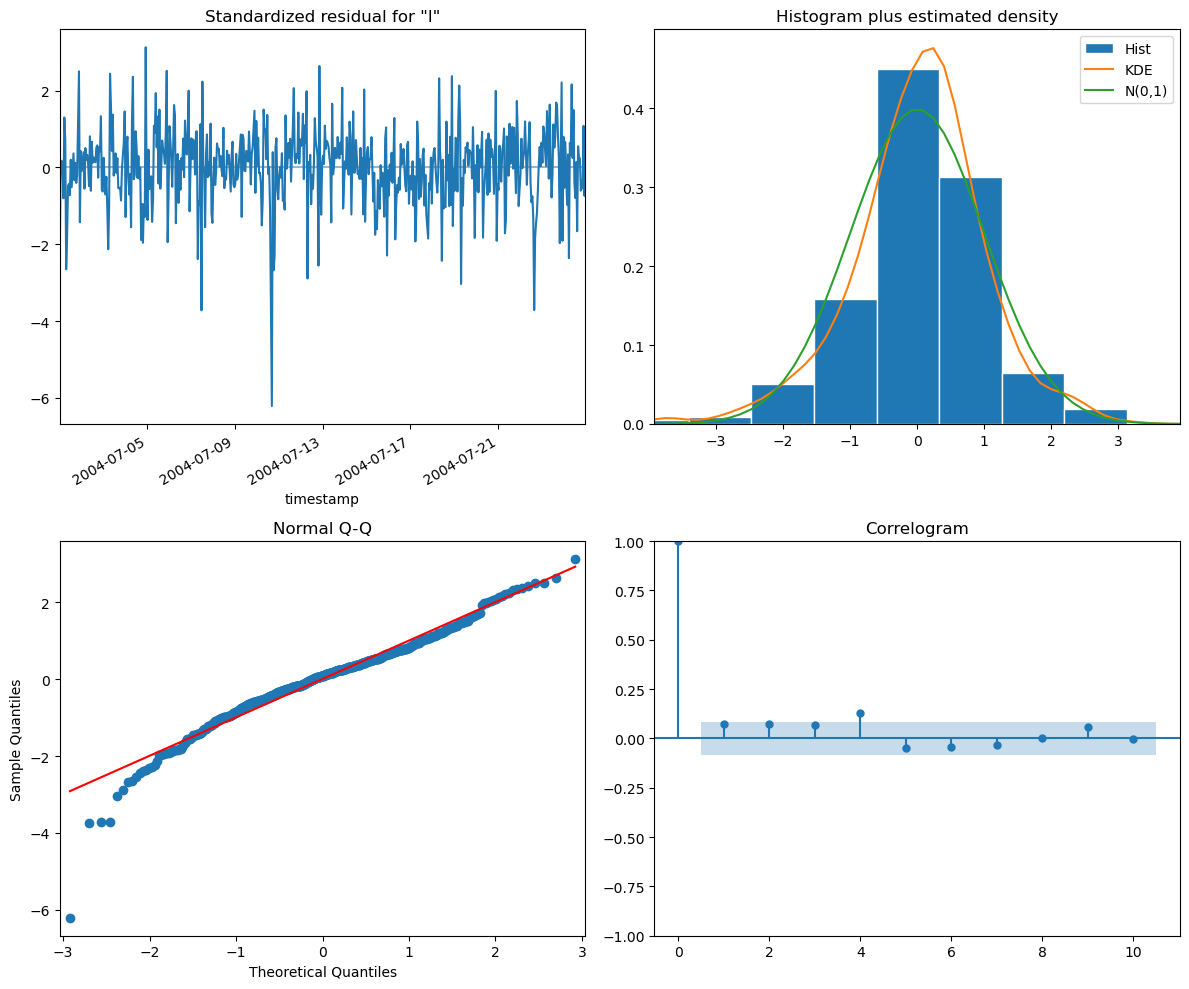

In [81]:
# Diagnostics; (3,0,0)(2,0,0)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jul_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(2,0,0,24), # seasonal: with no seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model is failing to converge, trying a model with lower order(s)...

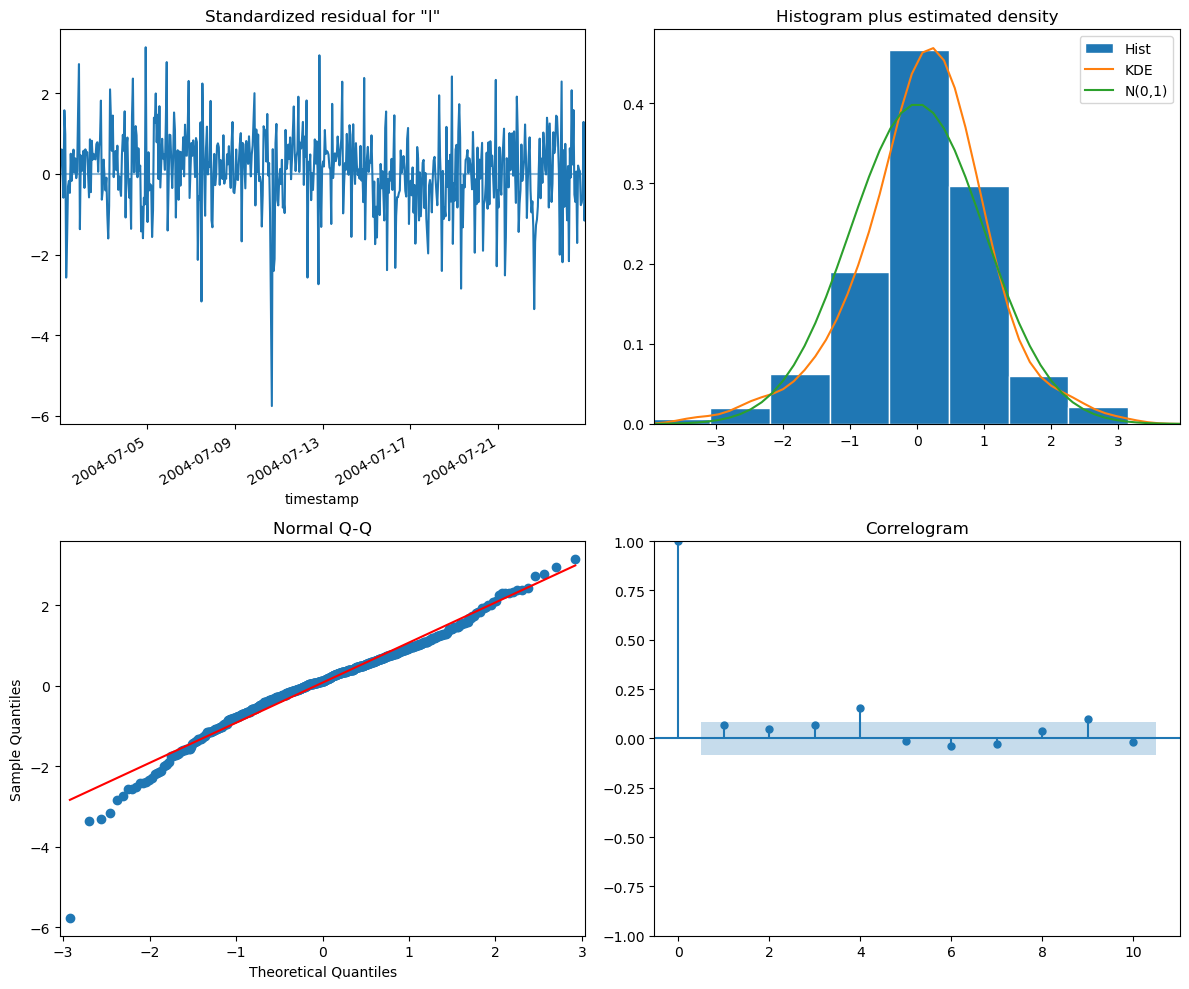

In [27]:
# Diagnostics FINAL MODEL; (3,0,0)(1,0,0)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jul_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(1,0,0,24), # seasonal: with no seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model successfully converged.

In [28]:
# Creating test data
load_long_z1_2004_jul_test = mul_df.loc[mul_df.month == 7,:]
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test.set_index("timestamp")
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test['2004-07-25 00:30:00':]
load_long_z1_2004_jul_test.index = pd.to_datetime(load_long_z1_2004_jul_test.index)
load_long_z1_2004_jul_test.head()

year  month  day   hour  log_load_rs  temp_weighted  HDK  \
timestamp                                                                       
2004-07-25 00:30:00  2004      7   25  00:30     2.669517      70.616043  0.0   
2004-07-25 01:30:00  2004      7   25  01:30     2.551552      70.893317  0.0   
2004-07-25 02:30:00  2004      7   25  02:30     2.486073      70.710504  0.0   
2004-07-25 03:30:00  2004      7   25  03:30     2.441738      70.526899  0.0   
2004-07-25 04:30:00  2004      7   25  04:30     2.429834      70.527349  0.0   

                          CDK  
timestamp                      
2004-07-25 00:30:00  5.616043  
2004-07-25 01:30:00  5.893317  
2004-07-25 02:30:00  5.710504  
2004-07-25 03:30:00  5.526899  
2004-07-25 04:30:00  5.527349

In [29]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jul_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=True,      # intercept
    order=1,              
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jul_test.head()

year  month  day   hour  log_load_rs  temp_weighted  HDK  \
timestamp                                                                       
2004-07-25 00:30:00  2004      7   25  00:30     2.669517      70.616043  0.0   
2004-07-25 01:30:00  2004      7   25  01:30     2.551552      70.893317  0.0   
2004-07-25 02:30:00  2004      7   25  02:30     2.486073      70.710504  0.0   
2004-07-25 03:30:00  2004      7   25  03:30     2.441738      70.526899  0.0   
2004-07-25 04:30:00  2004      7   25  04:30     2.429834      70.527349  0.0   

                          CDK  const  trend  sin(1,24)  cos(1,24)  sin(2,24)  \
timestamp                                                                      
2004-07-25 00:30:00  5.616043    1.0    1.0   0.000000   1.000000   0.000000   
2004-07-25 01:30:00  5.893317    1.0    2.0   0.258819   0.965926   0.500000   
2004-07-25 02:30:00  5.710504    1.0    3.0   0.500000   0.866025   0.866025   
2004-07-25 03:30:00  5.526899    1.0    4.0   0.707107   0.707107   1.000000   
2004-07-25 04:30:00  5.527349    1.0    5.0   0.866025   0.500000   0.866025   

                        cos(2,24)  
timestamp                          
2004-07-25 00:30:00  1.000000e+00  
2004-07-25 01:30:00  8.660254e-01  
2004-07-25 02:30:00  5.000000e-01  
2004-07-25 03:30:00  6.123234e-17  
2004-07-25 04:30:00 -5.000000e-01

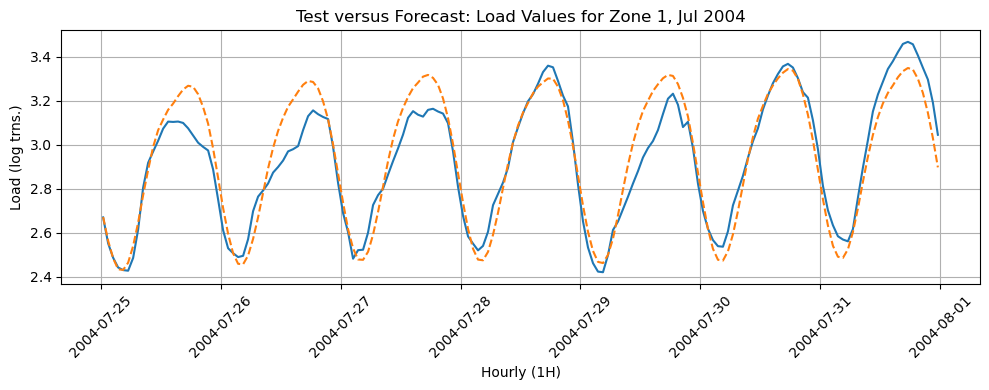

In [30]:
# Predicting 24*7 steps ahead
forecast_jul04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jul_test[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jul_test, x=load_long_z1_2004_jul_test.index, y=load_long_z1_2004_jul_test.log_load_rs, ax=ax)
sns.lineplot(forecast_jul04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jul 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [31]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}")
print(f'RMSE score: {np.sqrt(mean_squared_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')

R2 score: 0.8753462993701119
RMSE score: 0.09922004842527225
MAE score: 0.07866655769800422
MAPE score: 0.02666330043504136


##### Testing on Last Week of Oct 2004 (Zone 1)
Last week of Oct 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [32]:
# Creating training data
load_long_z1_2004_oct_train = mul_df.loc[mul_df.month == 10,:]
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train.set_index("timestamp")
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train[:'2004-10-24 23:30:00']
load_long_z1_2004_oct_train.index = pd.to_datetime(load_long_z1_2004_oct_train.index)
load_long_z1_2004_oct_train.head()

year  month  day   hour  log_load_rs  temp_weighted  HDK  \
timestamp                                                                       
2004-10-01 00:30:00  2004     10    1  00:30     2.410093      60.792180  0.0   
2004-10-01 01:30:00  2004     10    1  01:30     2.324444      60.513850  0.0   
2004-10-01 02:30:00  2004     10    1  02:30     2.293544      60.152501  0.0   
2004-10-01 03:30:00  2004     10    1  03:30     2.289399      59.693854  0.0   
2004-10-01 04:30:00  2004     10    1  04:30     2.303684      59.417333  0.0   

                     CDK  
timestamp                 
2004-10-01 00:30:00  0.0  
2004-10-01 01:30:00  0.0  
2004-10-01 02:30:00  0.0  
2004-10-01 03:30:00  0.0  
2004-10-01 04:30:00  0.0

In [33]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_oct_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=True,      # intercept
    order=1,             
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_oct_train.head()

year  month  day   hour  log_load_rs  temp_weighted  HDK  \
timestamp                                                                       
2004-10-01 00:30:00  2004     10    1  00:30     2.410093      60.792180  0.0   
2004-10-01 01:30:00  2004     10    1  01:30     2.324444      60.513850  0.0   
2004-10-01 02:30:00  2004     10    1  02:30     2.293544      60.152501  0.0   
2004-10-01 03:30:00  2004     10    1  03:30     2.289399      59.693854  0.0   
2004-10-01 04:30:00  2004     10    1  04:30     2.303684      59.417333  0.0   

                     CDK  const  trend  sin(1,24)  cos(1,24)  sin(2,24)  \
timestamp                                                                 
2004-10-01 00:30:00  0.0    1.0    1.0   0.000000   1.000000   0.000000   
2004-10-01 01:30:00  0.0    1.0    2.0   0.258819   0.965926   0.500000   
2004-10-01 02:30:00  0.0    1.0    3.0   0.500000   0.866025   0.866025   
2004-10-01 03:30:00  0.0    1.0    4.0   0.707107   0.707107   1.000000   
2004-10-01 04:30:00  0.0    1.0    5.0   0.866025   0.500000   0.866025   

                        cos(2,24)  
timestamp                          
2004-10-01 00:30:00  1.000000e+00  
2004-10-01 01:30:00  8.660254e-01  
2004-10-01 02:30:00  5.000000e-01  
2004-10-01 03:30:00  6.123234e-17  
2004-10-01 04:30:00 -5.000000e-01

In [90]:
# Comparing models - auto_arima (no differencing since regr res are stationary)

import pmdarima as pm
smodel_oct = pm.auto_arima(y = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_oct_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=3, max_Q=3, seasonal=True,
                           d=0, D=0, trace=True,
                           with_intercept=False,
                           trend=None,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-1442.882, Time=0.60 sec
 ARIMA(1,0,0)(1,0,0)[24]             : AIC=-2250.610, Time=4.96 sec
 ARIMA(0,0,1)(0,0,1)[24]             : AIC=-1460.151, Time=4.05 sec
 ARIMA(1,0,0)(0,0,0)[24]             : AIC=-2103.295, Time=1.00 sec
 ARIMA(1,0,0)(2,0,0)[24]             : AIC=-2259.452, Time=9.90 sec
 ARIMA(1,0,0)(3,0,0)[24]             : AIC=-2255.764, Time=28.70 sec
 ARIMA(1,0,0)(2,0,1)[24]             : AIC=-2250.043, Time=11.05 sec
 ARIMA(1,0,0)(1,0,1)[24]             : AIC=-2252.121, Time=2.66 sec
 ARIMA(1,0,0)(3,0,1)[24]             : AIC=-2253.919, Time=22.62 sec
 ARIMA(0,0,0)(2,0,0)[24]             : AIC=-1524.487, Time=4.18 sec
 ARIMA(2,0,0)(2,0,0)[24]             : AIC=-2395.233, Time=16.34 sec
 ARIMA(2,0,0)(1,0,0)[24]             : AIC=-2400.231, Time=5.13 sec
 ARIMA(2,0,0)(0,0,0)[24]             : AIC=-2260.723, Time=0.44 sec
 ARIMA(2,0,0)(1,0,1)[24]             : AIC=-2403.978, Time=4.82 sec
 

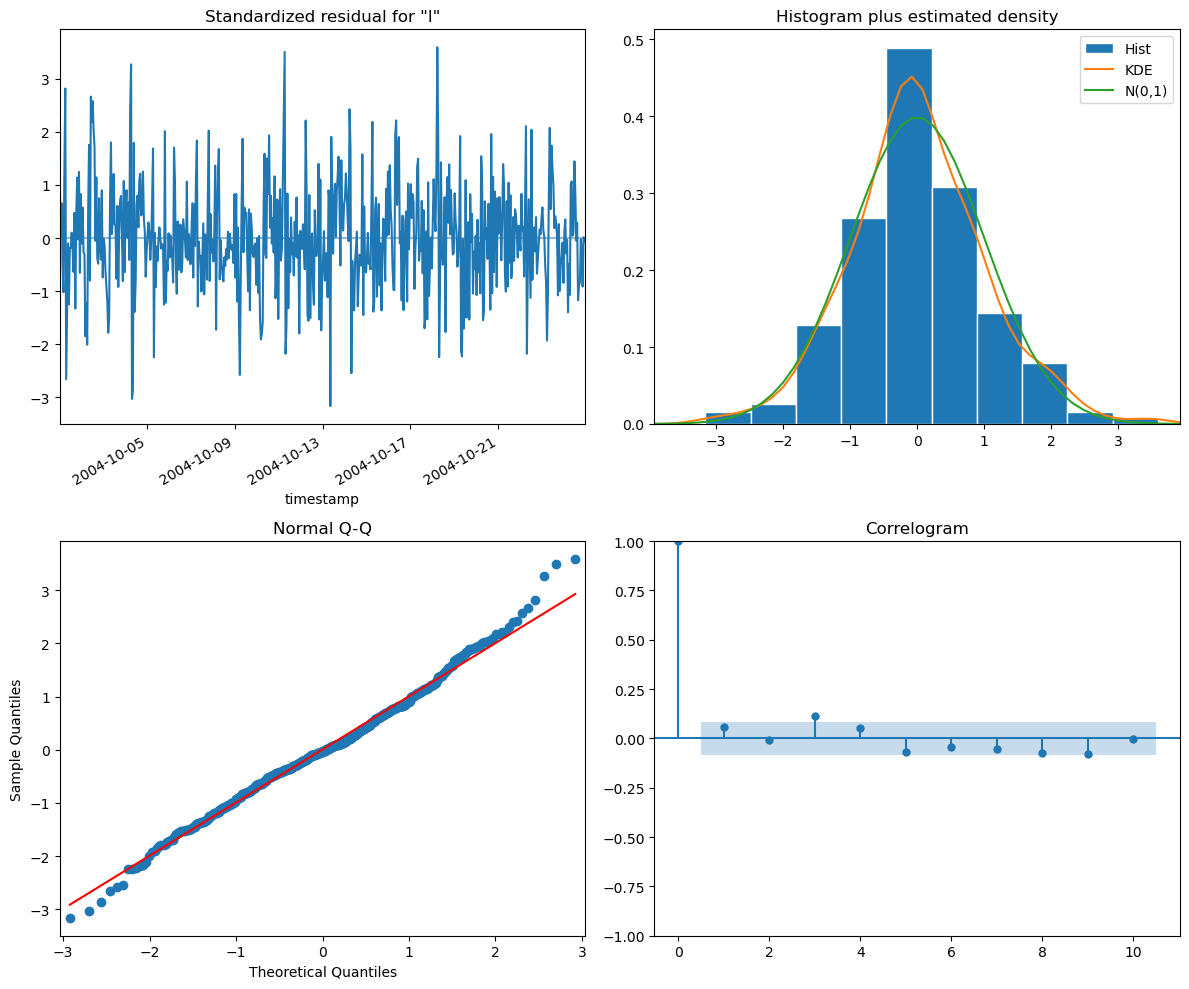

In [91]:
# Diagnostics; (3,0,0)(1,0,1)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_oct_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(1,0,1,24), # seasonal: with no seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model successfully converged.

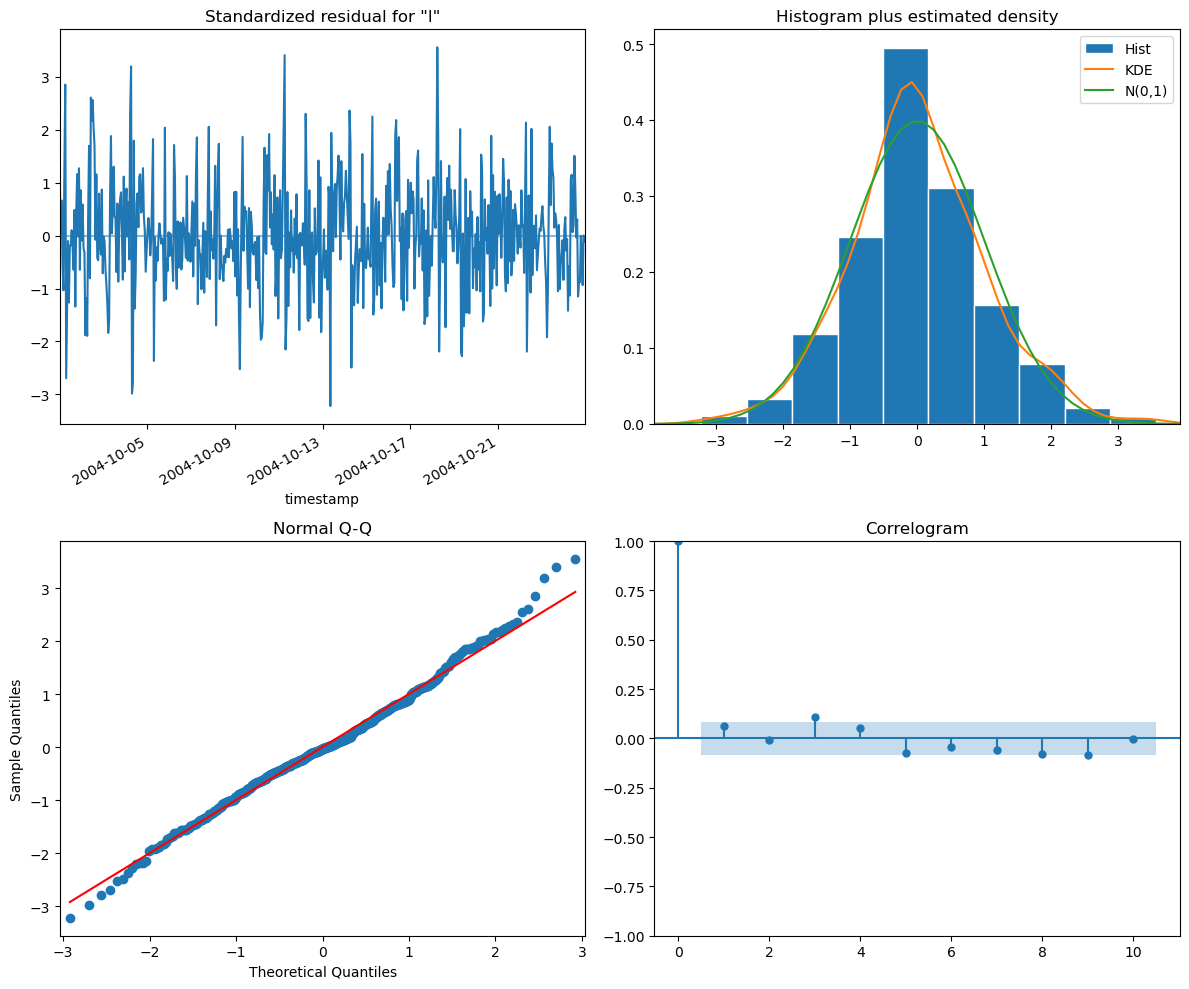

In [34]:
# Diagnostics FINAL MODEL; (3,0,0)(1,0,0)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_oct_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(1,0,0,24), # seasonal: with no seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [35]:
# Creating test data
load_long_z1_2004_oct_test = mul_df.loc[mul_df.month == 10,:]
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test.set_index("timestamp")
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test['2004-10-25 00:30:00':]
load_long_z1_2004_oct_test.index = pd.to_datetime(load_long_z1_2004_oct_test.index)
load_long_z1_2004_oct_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-25 00:30:00  2004     10   25  00:30     2.449970      50.290127   
2004-10-25 01:30:00  2004     10   25  01:30     2.407305      50.291859   
2004-10-25 02:30:00  2004     10   25  02:30     2.395164      50.658222   
2004-10-25 03:30:00  2004     10   25  03:30     2.396531      50.571048   
2004-10-25 04:30:00  2004     10   25  04:30     2.434403      50.467636   

                          HDK  CDK  
timestamp                           
2004-10-25 00:30:00  4.709873  0.0  
2004-10-25 01:30:00  4.708141  0.0  
2004-10-25 02:30:00  4.341778  0.0  
2004-10-25 03:30:00  4.428952  0.0  
2004-10-25 04:30:00  4.532364  0.0

In [36]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_oct_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=True,      # intercept
    order=1,              
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_oct_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-25 00:30:00  2004     10   25  00:30     2.449970      50.290127   
2004-10-25 01:30:00  2004     10   25  01:30     2.407305      50.291859   
2004-10-25 02:30:00  2004     10   25  02:30     2.395164      50.658222   
2004-10-25 03:30:00  2004     10   25  03:30     2.396531      50.571048   
2004-10-25 04:30:00  2004     10   25  04:30     2.434403      50.467636   

                          HDK  CDK  const  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                
2004-10-25 00:30:00  4.709873  0.0    1.0    1.0   0.000000   1.000000   
2004-10-25 01:30:00  4.708141  0.0    1.0    2.0   0.258819   0.965926   
2004-10-25 02:30:00  4.341778  0.0    1.0    3.0   0.500000   0.866025   
2004-10-25 03:30:00  4.428952  0.0    1.0    4.0   0.707107   0.707107   
2004-10-25 04:30:00  4.532364  0.0    1.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-10-25 00:30:00   0.000000  1.000000e+00  
2004-10-25 01:30:00   0.500000  8.660254e-01  
2004-10-25 02:30:00   0.866025  5.000000e-01  
2004-10-25 03:30:00   1.000000  6.123234e-17  
2004-10-25 04:30:00   0.866025 -5.000000e-01

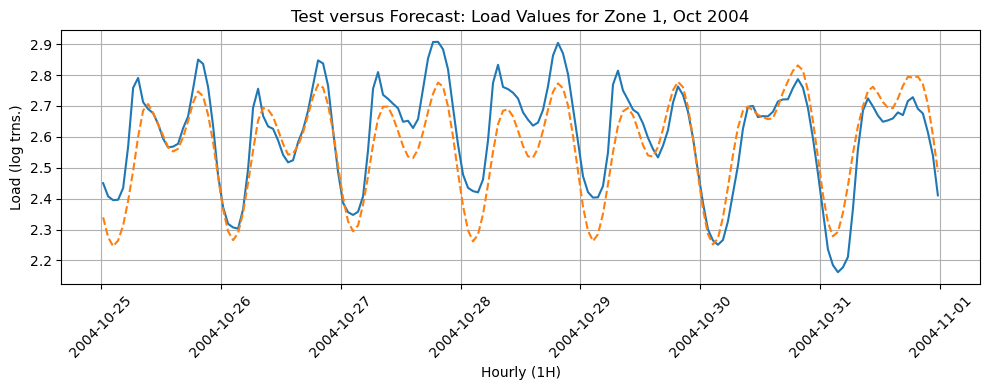

In [37]:
# Predicting 24*7 steps ahead
forecast_oct04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_oct_test[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_oct_test, x=load_long_z1_2004_oct_test.index, y=load_long_z1_2004_oct_test.log_load_rs, ax=ax)
sns.lineplot(forecast_oct04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Oct 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [38]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}")
print(f'RMSE score: {np.sqrt(mean_squared_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')

R2 score: 0.6998871375131461
RMSE score: 0.09205679734000612
MAE score: 0.07392992167706439
MAPE score: 0.028428161183065986


##### Testing on Last Week of Dec 2004 (Zone 1)
Last week of Dec 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [39]:
# Creating training data
load_long_z1_2004_dec_train = mul_df.loc[mul_df.month == 12,:]
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train.set_index("timestamp")
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train[:'2004-12-24 23:30:00']
load_long_z1_2004_dec_train.index = pd.to_datetime(load_long_z1_2004_dec_train.index)
load_long_z1_2004_dec_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-01 00:30:00  2004     12    1  00:30     2.650774      47.965991   
2004-12-01 01:30:00  2004     12    1  01:30     2.609481      48.609925   
2004-12-01 02:30:00  2004     12    1  02:30     2.608304      49.154281   
2004-12-01 03:30:00  2004     12    1  03:30     2.617177      50.252969   
2004-12-01 04:30:00  2004     12    1  04:30     2.646104      51.607521   

                          HDK  CDK  
timestamp                           
2004-12-01 00:30:00  7.034009  0.0  
2004-12-01 01:30:00  6.390075  0.0  
2004-12-01 02:30:00  5.845719  0.0  
2004-12-01 03:30:00  4.747031  0.0  
2004-12-01 04:30:00  3.392479  0.0

In [40]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_dec_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=True,      # intercept
    order=1,             
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_dec_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-01 00:30:00  2004     12    1  00:30     2.650774      47.965991   
2004-12-01 01:30:00  2004     12    1  01:30     2.609481      48.609925   
2004-12-01 02:30:00  2004     12    1  02:30     2.608304      49.154281   
2004-12-01 03:30:00  2004     12    1  03:30     2.617177      50.252969   
2004-12-01 04:30:00  2004     12    1  04:30     2.646104      51.607521   

                          HDK  CDK  const  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                
2004-12-01 00:30:00  7.034009  0.0    1.0    1.0   0.000000   1.000000   
2004-12-01 01:30:00  6.390075  0.0    1.0    2.0   0.258819   0.965926   
2004-12-01 02:30:00  5.845719  0.0    1.0    3.0   0.500000   0.866025   
2004-12-01 03:30:00  4.747031  0.0    1.0    4.0   0.707107   0.707107   
2004-12-01 04:30:00  3.392479  0.0    1.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-12-01 00:30:00   0.000000  1.000000e+00  
2004-12-01 01:30:00   0.500000  8.660254e-01  
2004-12-01 02:30:00   0.866025  5.000000e-01  
2004-12-01 03:30:00   1.000000  6.123234e-17  
2004-12-01 04:30:00   0.866025 -5.000000e-01

In [98]:
# Comparing models - auto_arima (no differencing since regr res are stationary)

import pmdarima as pm
smodel_dec = pm.auto_arima(y = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=3, max_Q=3, seasonal=True,
                           d=0, D=0, trace=True,
                           with_intercept=False,
                           trend=None,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-1198.082, Time=0.68 sec
 ARIMA(1,0,0)(1,0,0)[24]             : AIC=-2354.329, Time=5.61 sec
 ARIMA(0,0,1)(0,0,1)[24]             : AIC=-1204.869, Time=4.41 sec
 ARIMA(1,0,0)(0,0,0)[24]             : AIC=-2126.684, Time=0.28 sec
 ARIMA(1,0,0)(2,0,0)[24]             : AIC=-2349.435, Time=14.92 sec
 ARIMA(1,0,0)(1,0,1)[24]             : AIC=-2233.686, Time=2.25 sec
 ARIMA(1,0,0)(0,0,1)[24]             : AIC=-2309.692, Time=5.71 sec
 ARIMA(1,0,0)(2,0,1)[24]             : AIC=-2188.569, Time=8.43 sec
 ARIMA(0,0,0)(1,0,0)[24]             : AIC=-1236.216, Time=3.87 sec
 ARIMA(2,0,0)(1,0,0)[24]             : AIC=-2393.615, Time=4.97 sec
 ARIMA(2,0,0)(0,0,0)[24]             : AIC=-2218.800, Time=0.43 sec
 ARIMA(2,0,0)(2,0,0)[24]             : AIC=-2440.089, Time=16.95 sec
 ARIMA(2,0,0)(3,0,0)[24]             : AIC=-2445.357, Time=36.23 sec
 ARIMA(2,0,0)(3,0,1)[24]             : AIC=-2455.247, Time=39.38 sec
 

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


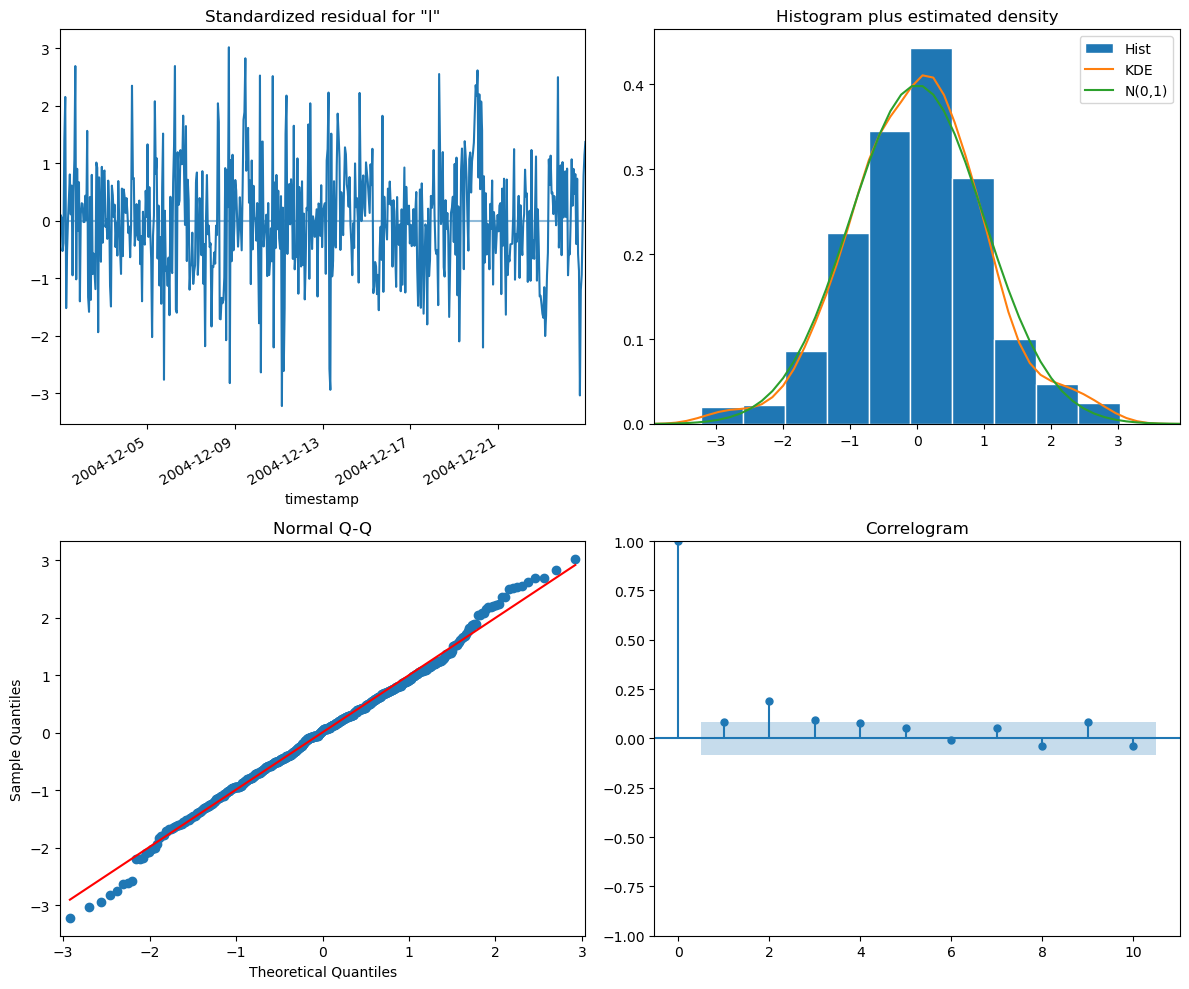

In [99]:
# Diagnostics; (3,0,0)(3,0,1)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(3,0,1,24), # seasonal: with seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model is failing to converge, trying a simpler model with slightly lower order(s)...

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


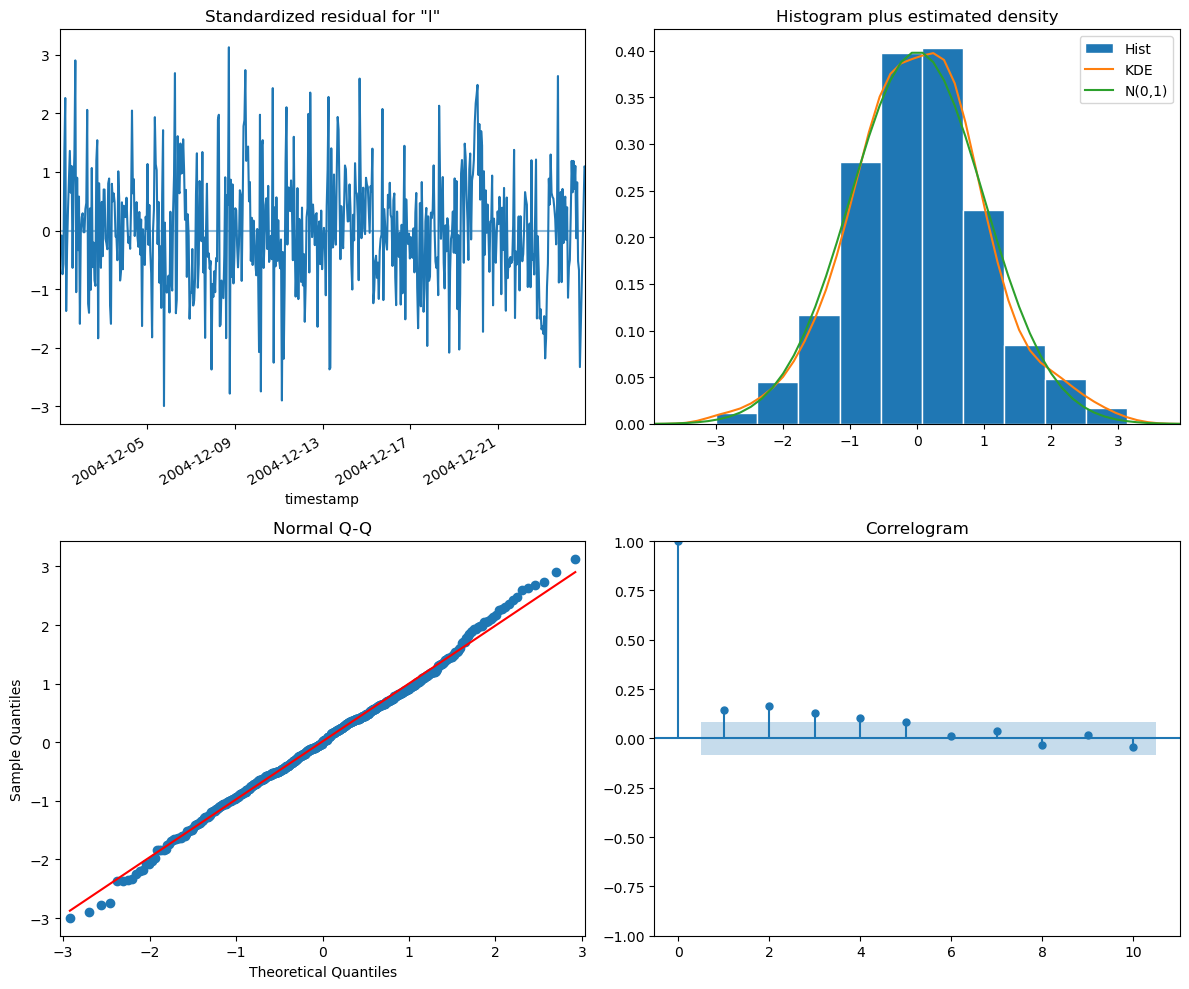

In [100]:
# Diagnostics; (3,0,0)(3,0,0)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(3,0,0,24), # seasonal: with seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model is failing to converge, trying a different model with slightly lower order(s)...

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


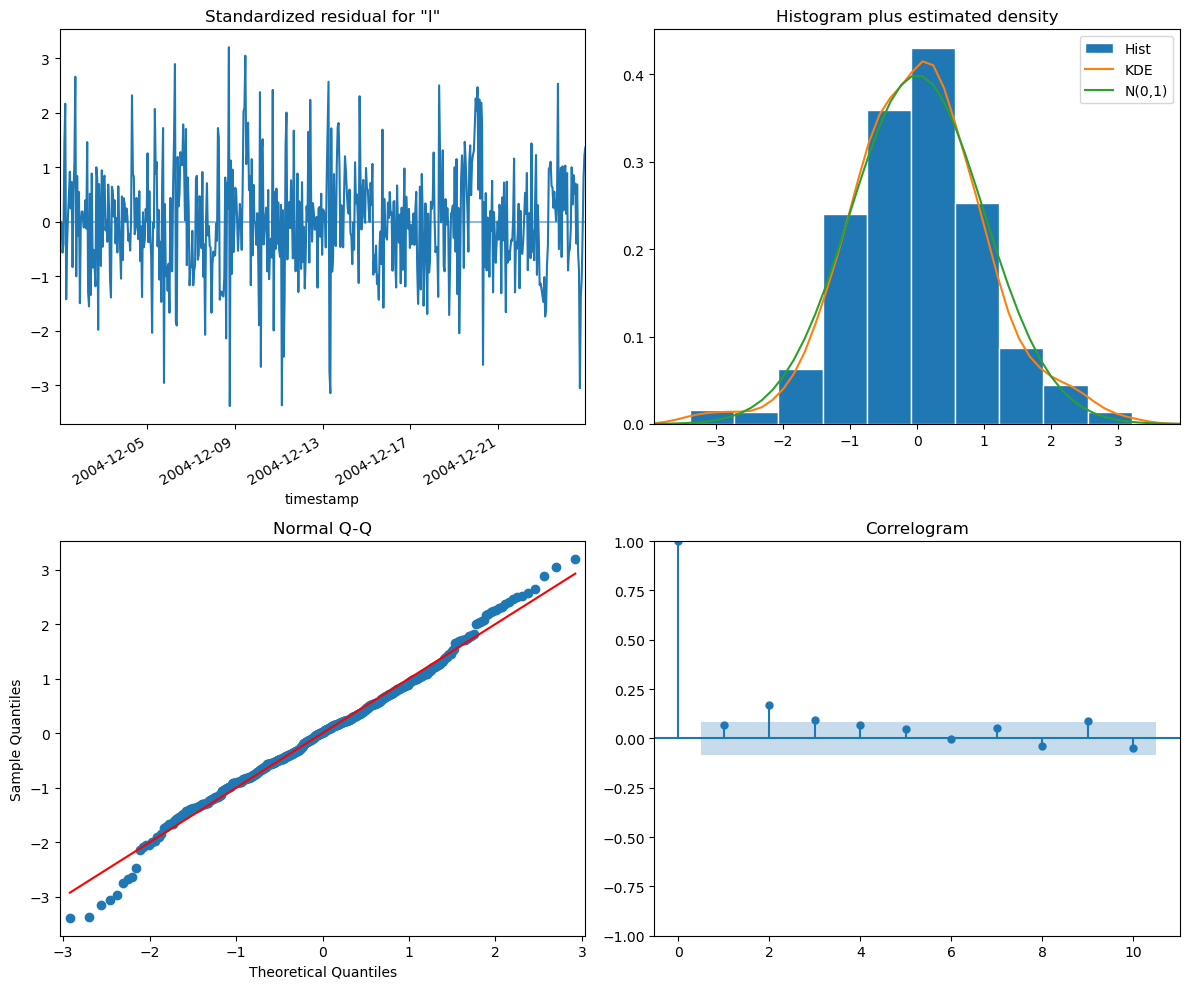

In [101]:
# Diagnostics; (3,0,0)(2,0,1)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(2,0,1,24), # seasonal: with seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model is failing to converge, trying a different model with slightly lower order(s)...

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


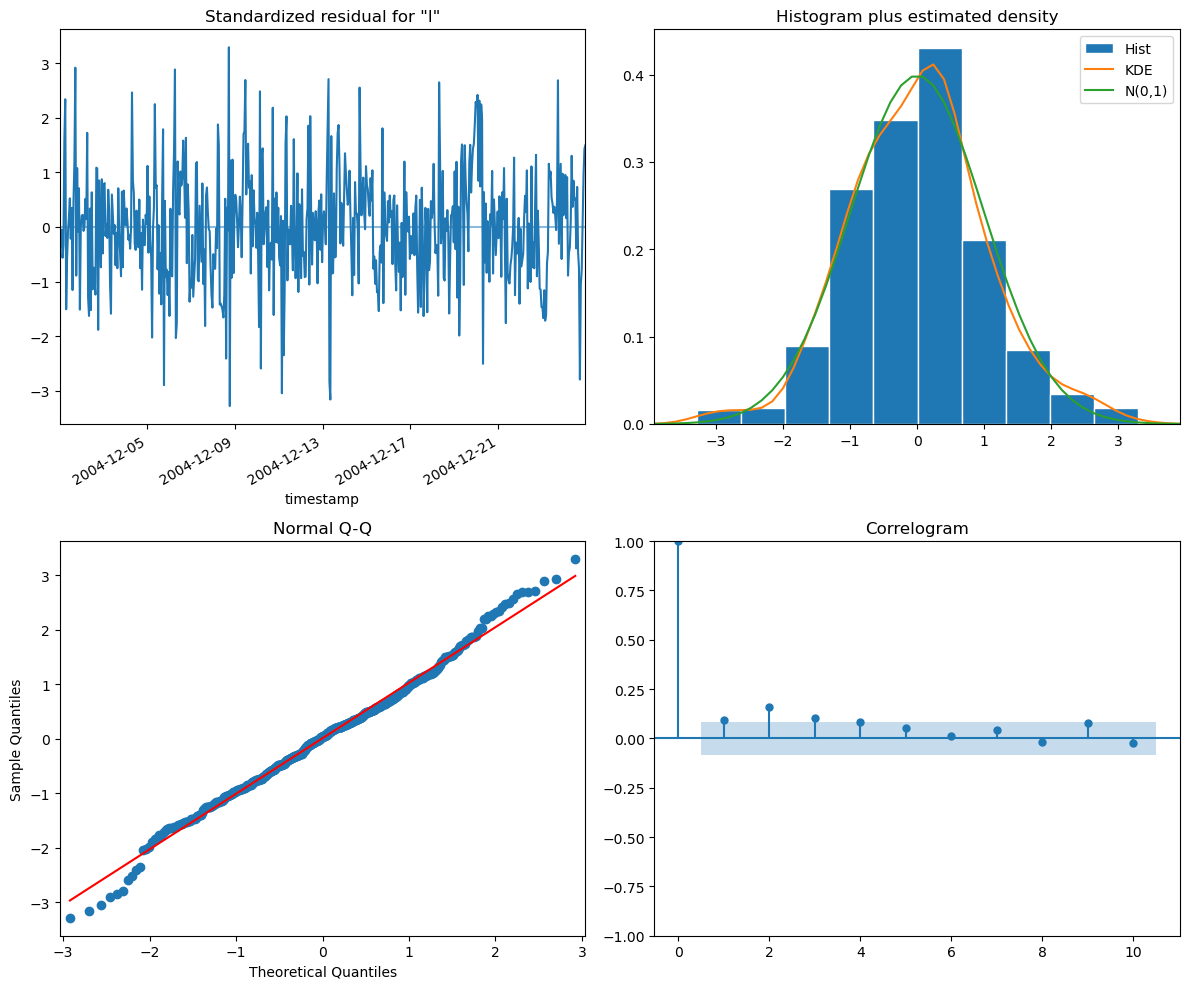

In [102]:
# Diagnostics; (3,0,0)(2,0,0)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(2,0,0,24), # seasonal: with seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model is failing to converge, trying a different model with slightly lower order(s)...

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


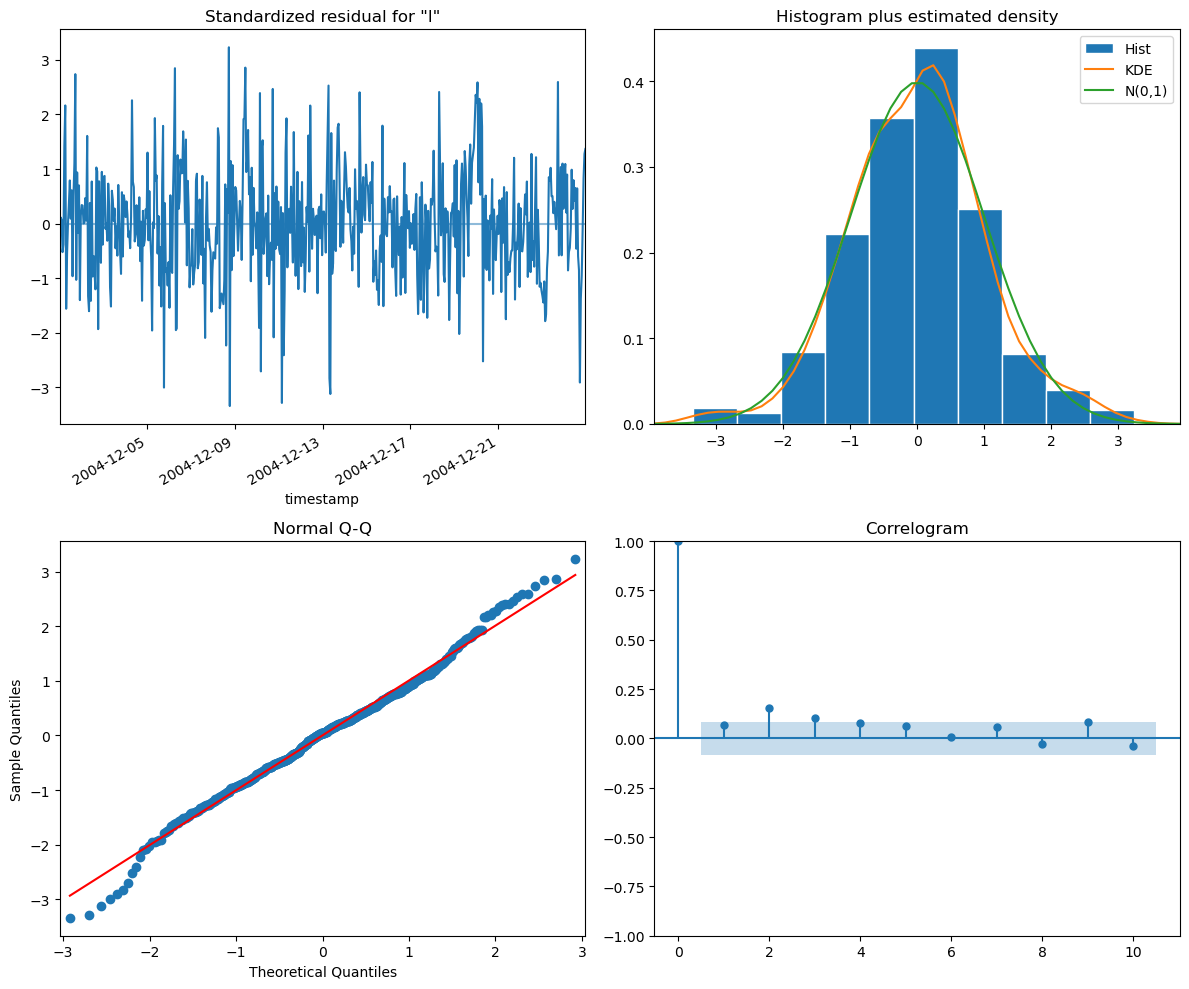

In [103]:
# Diagnostics; (3,0,0)(1,0,1)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(1,0,1,24), # seasonal: with seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model is failing to converge, trying a different model with slightly lower order(s)...

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


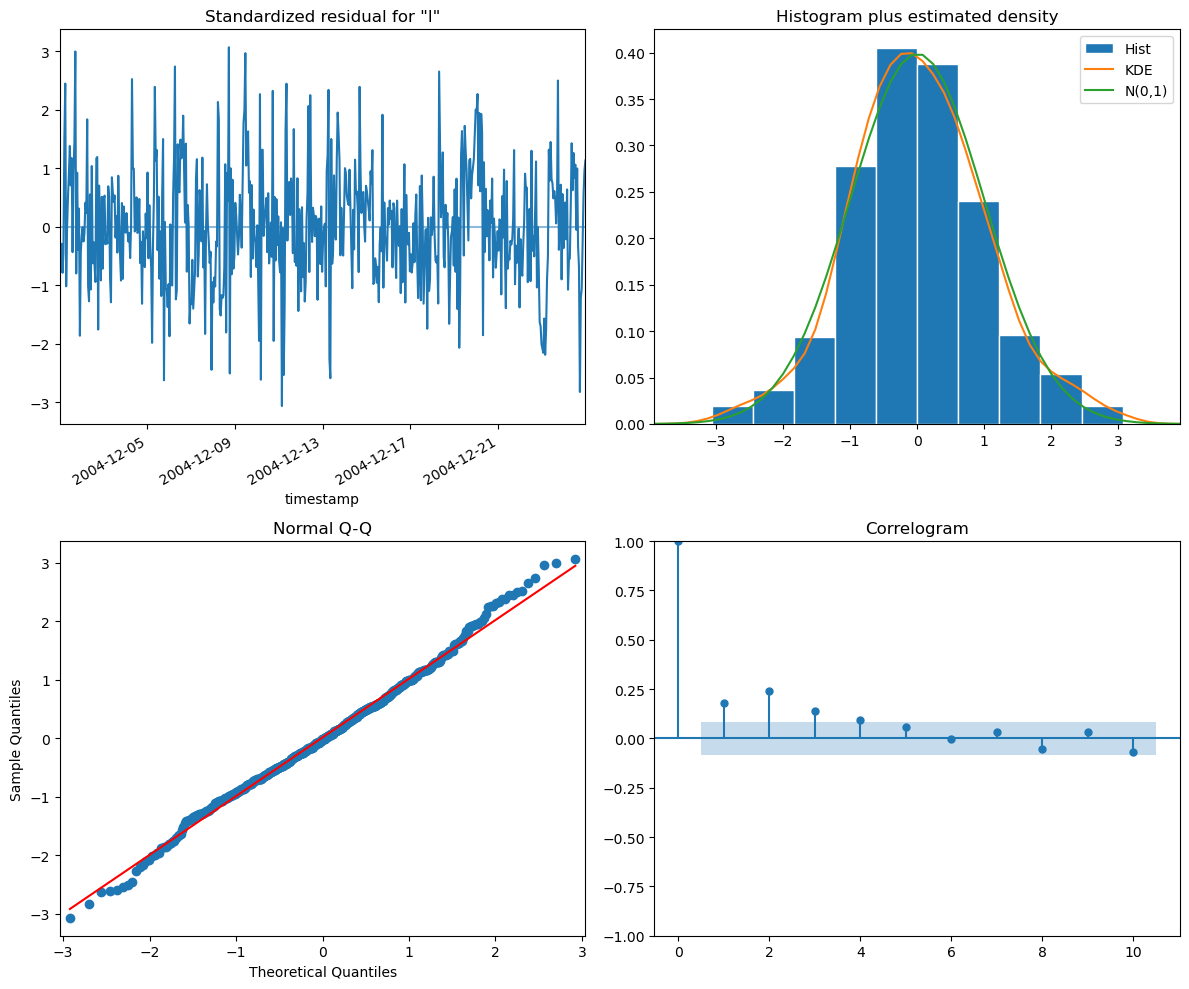

In [111]:
# Diagnostics; (3,0,0)(3,0,2)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(3,0,2,24), # seasonal: with seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model is failing to converge, trying a different model with slightly lower order(s)...

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


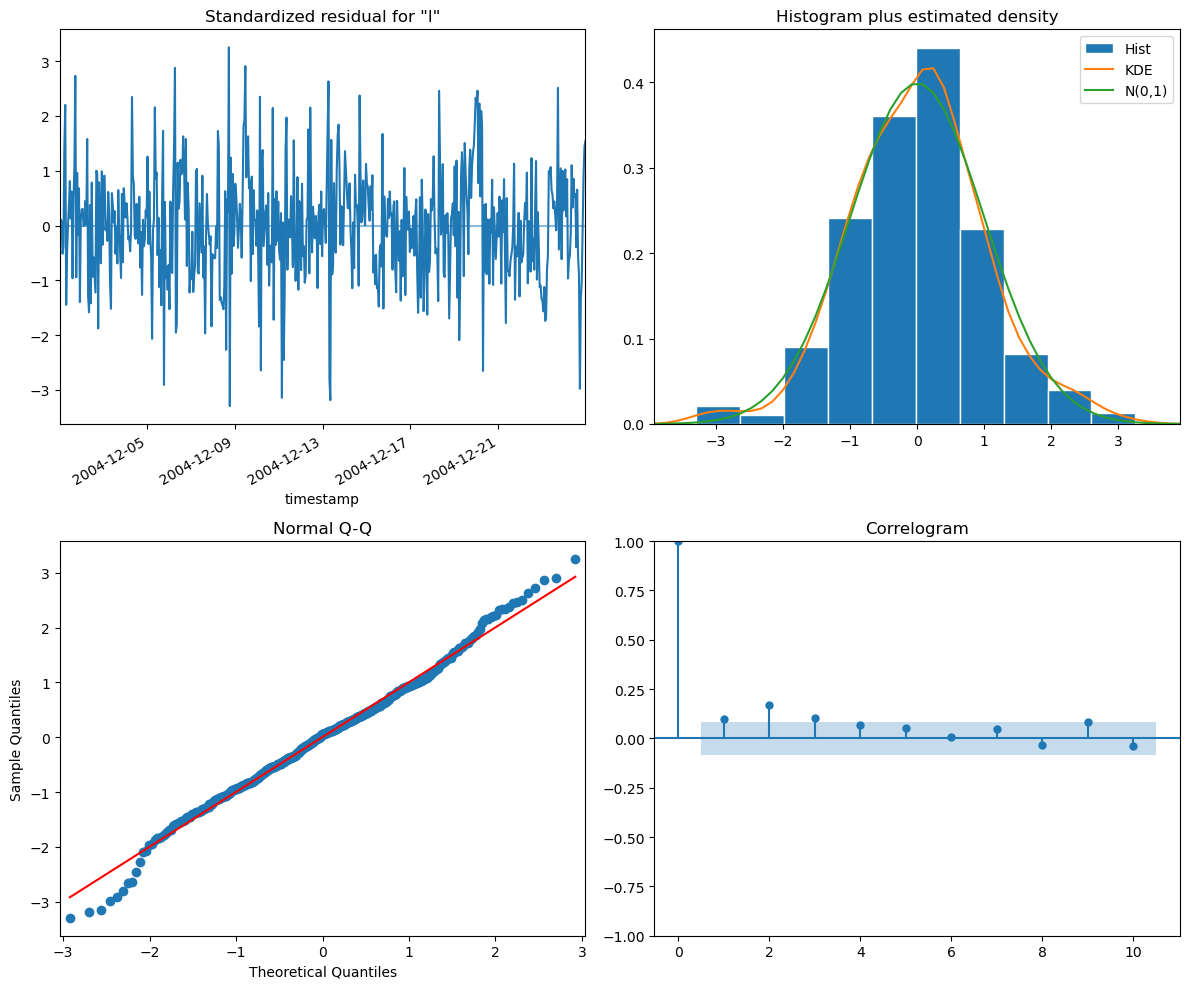

In [112]:
# Diagnostics; (3,0,0)(2,0,2)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(2,0,2,24), # seasonal: with seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model is failing to converge, trying a different model with slightly lower order(s)...

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


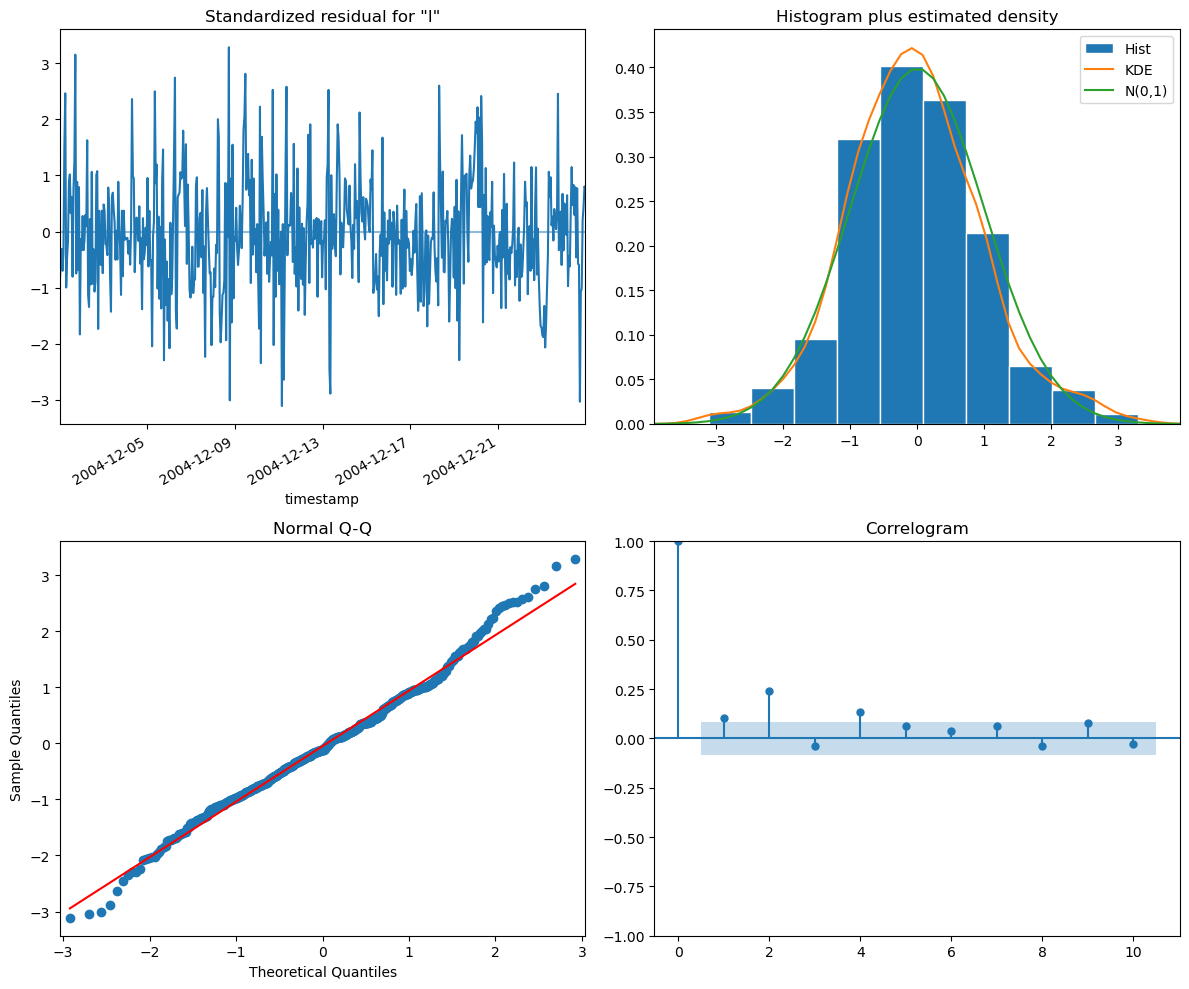

In [113]:
# Diagnostics; (3,0,1)(3,0,1)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,1),  # non-seasonal: with no differencing
        seasonal_order=(3,0,1,24), # seasonal: with seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model is failing to converge, trying a different model with slightly lower order(s)...

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


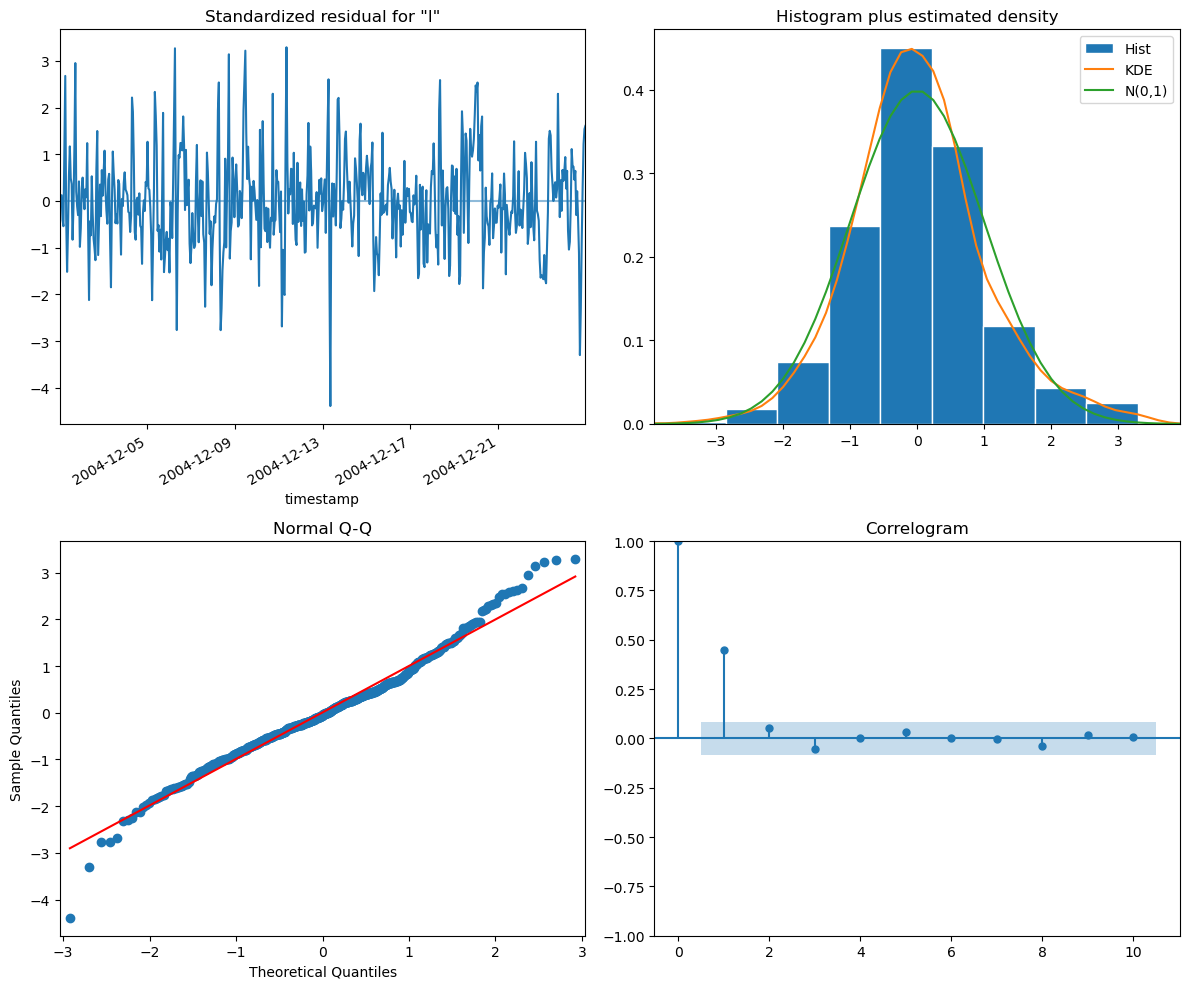

In [114]:
# Diagnostics; (1,0,0)(3,0,1)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(1,0,0),  # non-seasonal: with no differencing
        seasonal_order=(3,0,1,24), # seasonal: with seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model is failing to converge, trying a different model with slightly lower order(s)...

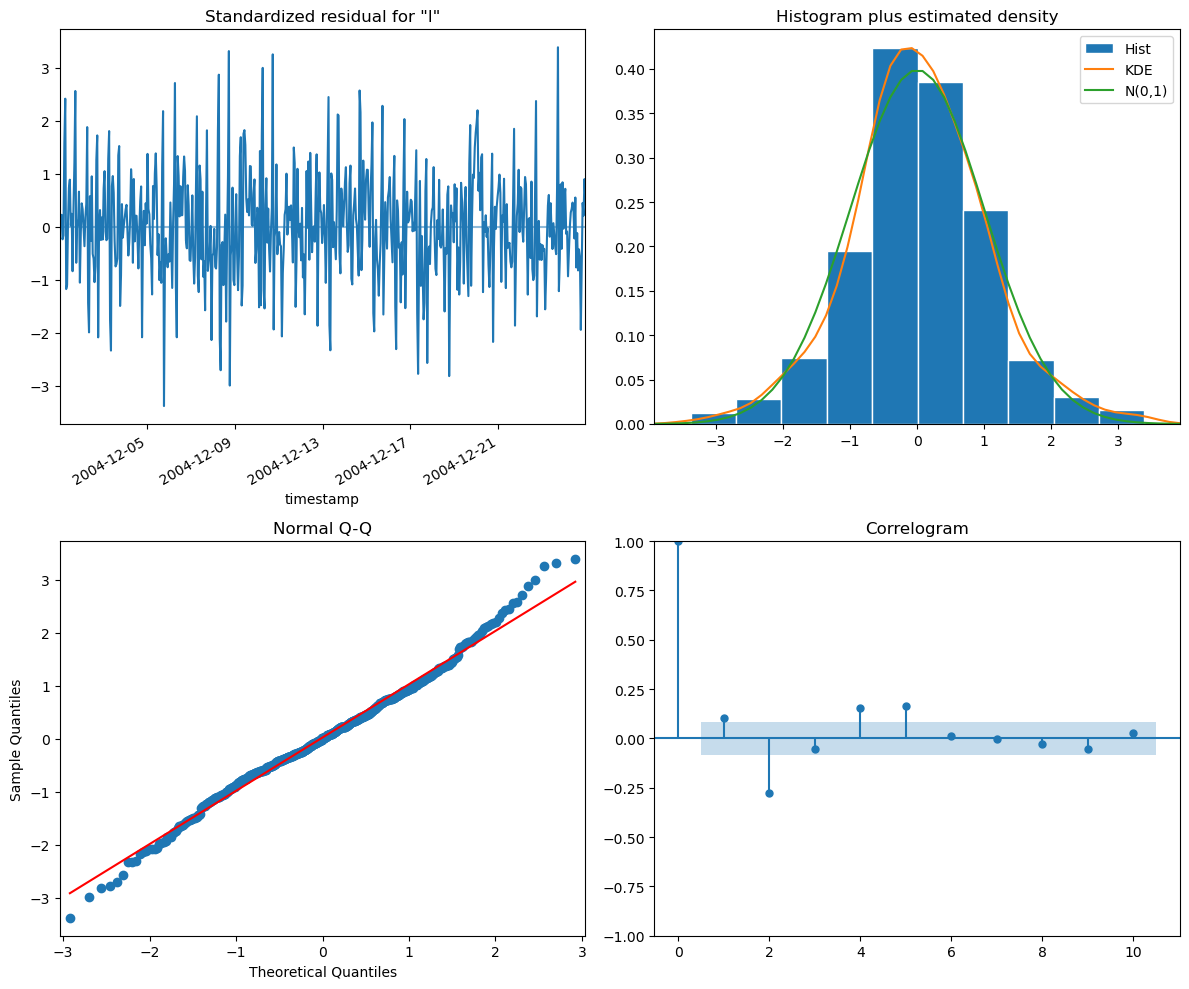

In [116]:
# Diagnostics; (2,0,0)(2,0,2)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(2,0,0),  # non-seasonal: with no differencing
        seasonal_order=(2,0,2,24), # seasonal: with seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model successfully converges, however there is still uncaptured serial dependence according to Correlogram.

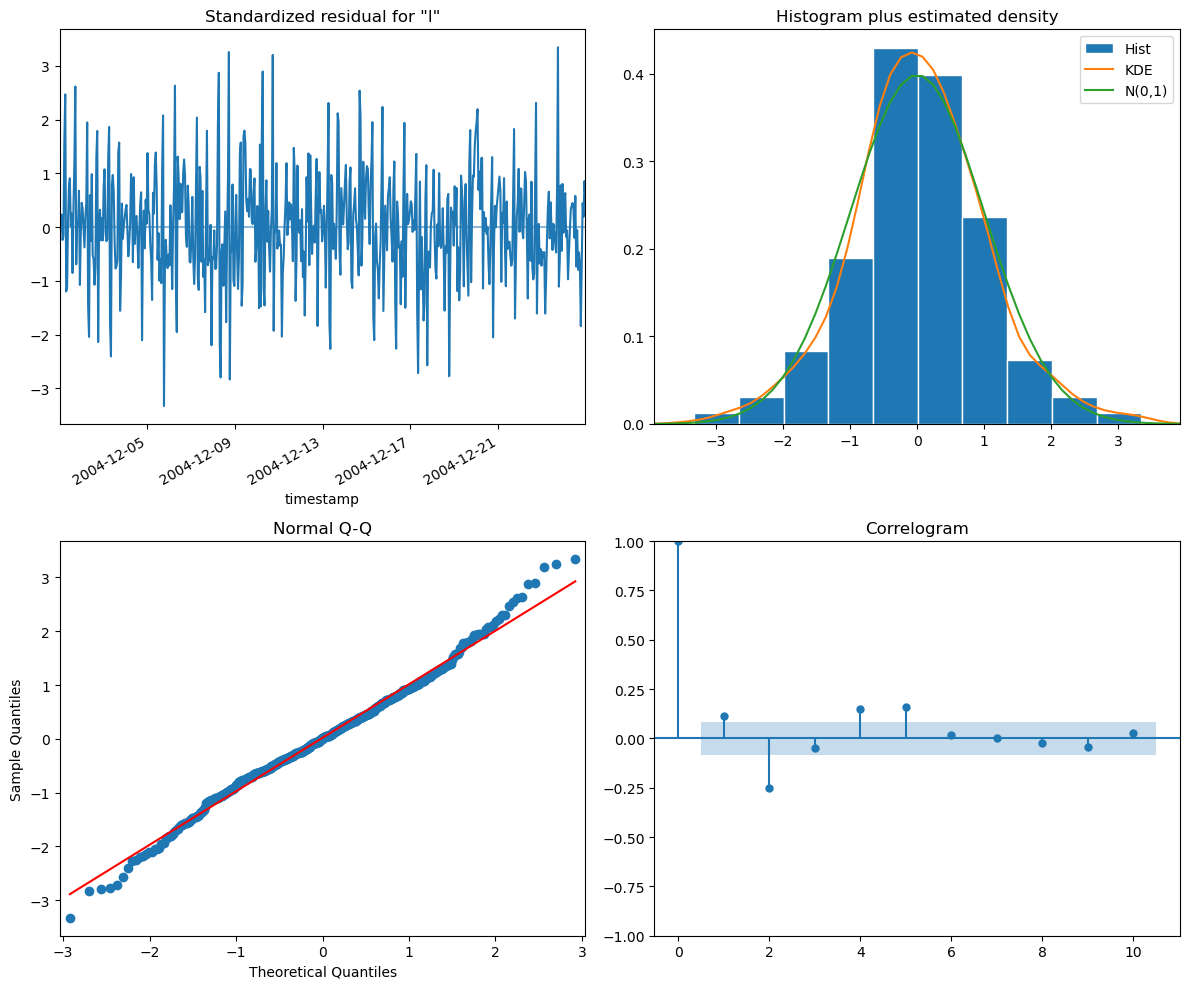

In [117]:
# Diagnostics; (2,0,0)(3,0,2)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(2,0,0),  # non-seasonal: with no differencing
        seasonal_order=(3,0,2,24), # seasonal: with seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model successfully converges, however there is still uncaptured serial dependence according to Correlogram.

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


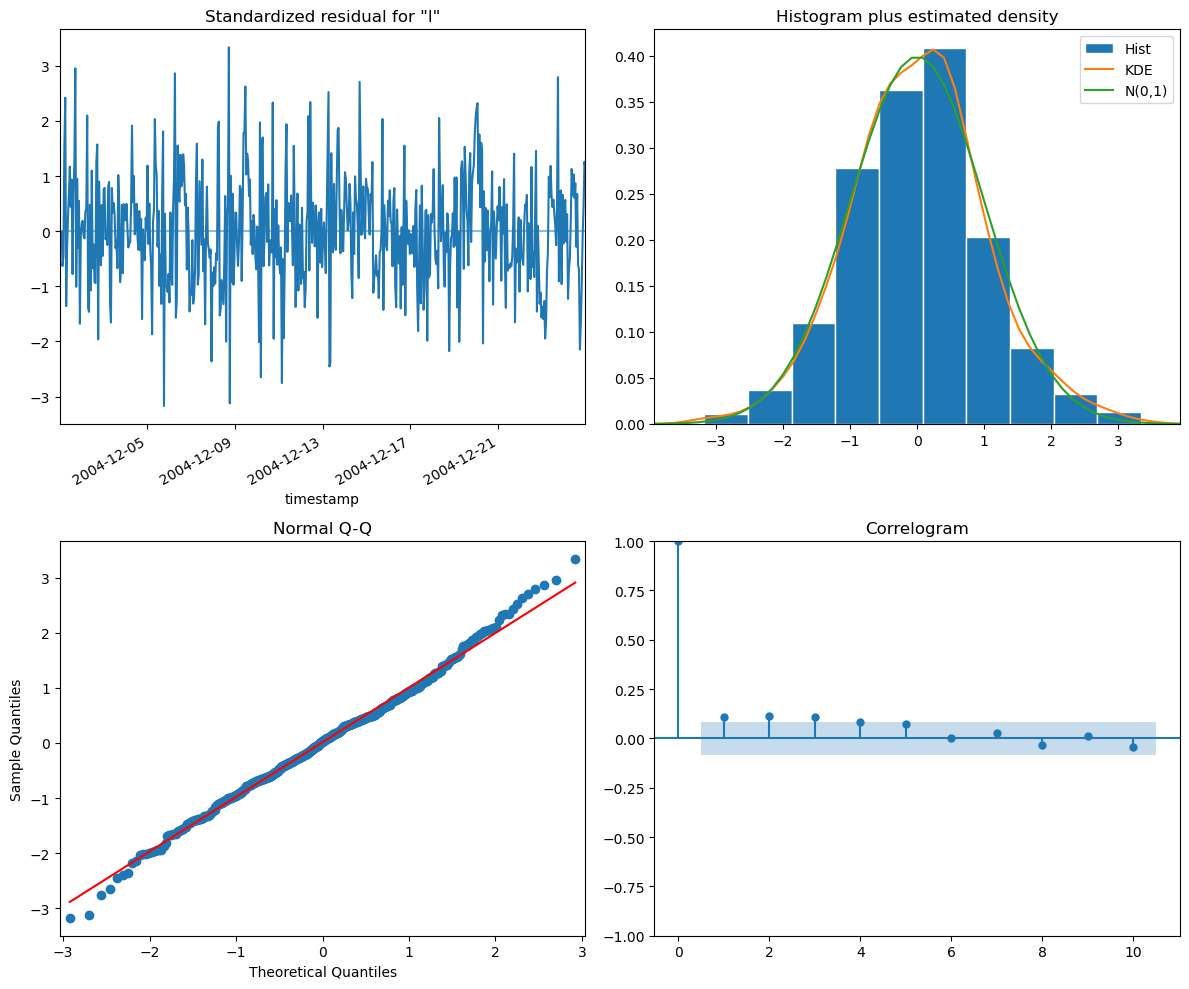

In [41]:
# Diagnostics FINAL MODEL; (3,0,0)(1,0,0)

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(1,0,0,24), # seasonal: with seasonal differencing
        trend=None
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Model successfully converges and Correlogram is much better!

In [42]:
# AIC of the model
SARIMA_model_fit.aic

-2430.934027653886

In [43]:
# Creating test data
load_long_z1_2004_dec_test = mul_df.loc[mul_df.month == 12,:]
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test.set_index("timestamp")
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test['2004-12-25 00:30:00':]
load_long_z1_2004_dec_test.index = pd.to_datetime(load_long_z1_2004_dec_test.index)
load_long_z1_2004_dec_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-25 00:30:00  2004     12   25  00:30     3.270443      25.586955   
2004-12-25 01:30:00  2004     12   25  01:30     3.272530      24.675567   
2004-12-25 02:30:00  2004     12   25  02:30     3.290191      24.681275   
2004-12-25 03:30:00  2004     12   25  03:30     3.314804      24.588997   
2004-12-25 04:30:00  2004     12   25  04:30     3.350676      24.320518   

                           HDK  CDK  
timestamp                            
2004-12-25 00:30:00  29.413045  0.0  
2004-12-25 01:30:00  30.324433  0.0  
2004-12-25 02:30:00  30.318725  0.0  
2004-12-25 03:30:00  30.411003  0.0  
2004-12-25 04:30:00  30.679482  0.0

In [44]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_dec_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=True,      # intercept
    order=1,              
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_dec_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-25 00:30:00  2004     12   25  00:30     3.270443      25.586955   
2004-12-25 01:30:00  2004     12   25  01:30     3.272530      24.675567   
2004-12-25 02:30:00  2004     12   25  02:30     3.290191      24.681275   
2004-12-25 03:30:00  2004     12   25  03:30     3.314804      24.588997   
2004-12-25 04:30:00  2004     12   25  04:30     3.350676      24.320518   

                           HDK  CDK  const  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                 
2004-12-25 00:30:00  29.413045  0.0    1.0    1.0   0.000000   1.000000   
2004-12-25 01:30:00  30.324433  0.0    1.0    2.0   0.258819   0.965926   
2004-12-25 02:30:00  30.318725  0.0    1.0    3.0   0.500000   0.866025   
2004-12-25 03:30:00  30.411003  0.0    1.0    4.0   0.707107   0.707107   
2004-12-25 04:30:00  30.679482  0.0    1.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-12-25 00:30:00   0.000000  1.000000e+00  
2004-12-25 01:30:00   0.500000  8.660254e-01  
2004-12-25 02:30:00   0.866025  5.000000e-01  
2004-12-25 03:30:00   1.000000  6.123234e-17  
2004-12-25 04:30:00   0.866025 -5.000000e-01

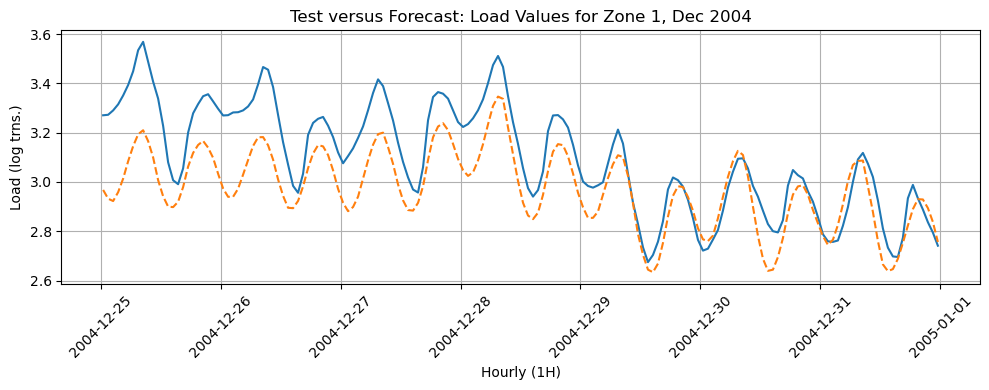

In [45]:
# Predicting 24*7 steps ahead
forecast_dec04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_dec_test[["HDK", "CDK", "const", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_dec_test, x=load_long_z1_2004_dec_test.index, y=load_long_z1_2004_dec_test.log_load_rs, ax=ax)
sns.lineplot(forecast_dec04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Dec 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [46]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}")
print(f'RMSE score: {np.sqrt(mean_squared_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')

R2 score: 0.42260798251566645
RMSE score: 0.16460046411434168
MAE score: 0.1355581273304334
MAPE score: 0.042414668875581325


### Conclusion
SARIMAX(0,0,0)(0,0,0) is performing better compared to the same model with higher order AR/MA components. It appears that harmonics are competing with SARIMA terms to explain variation in the data.